# OFCOM Survey Data Analysis & Visualisation

## 1. Importing necessary Libraries & Modules

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import datetime as dt

## 2. Loading the OFCOM survey data, Regional COVID Cases, Mortality Data and Vaccination Data and UK cases/mortality data 
### Loading the OFCOM data:

In [2]:
path_for_datasets = '/Users/alexandrahowland/Documents/CFG-Group-1-Data-Final-Project/report/visualisation/1_data_cleaning_preprocessing/2_cleaned_files/ofcom_survey_data'

directory_path = Path(path_for_datasets)

file_list = [f.name for f in directory_path.iterdir() if f.is_file()]

file_paths = [f'{path_for_datasets}/{file}' for file in file_list if file[-4:] == '.csv']

ofcom_dataframes = {}
for i, file_path in enumerate(file_paths):
    dataframe = pd.read_csv(file_path)
    
    dataframe['start_date'] = pd.to_datetime(dataframe['start_date'], errors='coerce')
    dataframe['end_date'] = pd.to_datetime(dataframe['end_date'], errors='coerce')
    
    dataframe['start_date'] = dataframe['start_date'].dt.date
    dataframe['end_date'] = dataframe['end_date'].dt.date
    
    ofcom_dataframes[file_list[i][:-12]] = dataframe
    

In [3]:
dataframe['start_date'] = pd.to_datetime(dataframe['start_date'], errors='coerce')
dataframe['end_date'] = pd.to_datetime(dataframe['end_date'], errors='coerce')

dataframe['start_date'] = dataframe['start_date'].dt.date
dataframe['end_date'] = dataframe['end_date'].dt.date

### Loading the ukhsa regional information for mortality, vaccination and cases

In [4]:
ukhsa_mortality_dataframe = pd.read_csv('1_data_cleaning_preprocessing/2_cleaned_files/ukhsa_mortality_data/uk_regional_covid_mortality_cleaned.csv')

In [5]:
ukhsa_cases_dataframe = pd.read_csv('1_data_cleaning_preprocessing/2_cleaned_files/ukhsa_cases_data/ukhsa_cases_data_cleaned.csv')

In [6]:
ukhsa_vaccination_dataframe = pd.read_csv('1_data_cleaning_preprocessing/2_cleaned_files/ukhsa_vaccination_data/ukhsa_vaccination_data_cleaned.csv')

### Loading the UK COVID API data 

In [7]:
covid_api_uk_dataframe = pd.read_csv('1_data_cleaning_preprocessing/1_api_connectors_and_csv_parsers/2_processed_databases/covid_19_api_data/17_03_2020_29_11_2024_GBR.csv')

In [8]:
covid_api_uk_dataframe = covid_api_uk_dataframe[covid_api_uk_dataframe['province'].isin(['United Kingdom', 'England', 'Scotland', 'Wales'])]

# 3. Frequency of getting information and news on the pandemic
## I first get the corresponding dataframe

In [9]:
dataframe = ofcom_dataframes['frequency_of_getting_infonews_about_coronavirus_outbreak_in_last_week']

## I ensure that the dates are appropriately formatted

In [10]:
dataframe['start_date'] = pd.to_datetime(dataframe['start_date'], errors='coerce')
dataframe['end_date'] = pd.to_datetime(dataframe['end_date'], errors='coerce')

dataframe['start_date'] = dataframe['start_date'].dt.date
dataframe['end_date'] = dataframe['end_date'].dt.date

## I want to plot the percentage of respondants over time so I need to create a dataframe which contains unique dates and weighted bases from the dataframe and calculate the percentage of respondents

In [11]:
weighted_bases = dataframe[dataframe['response'] == 'Weighted base'][['start_date', 'total']].reset_index(drop=True)

In [12]:
def get_total(start_date):
    lookup_dict = weighted_bases.set_index('start_date')['total'].to_dict()
    
    return lookup_dict.get(start_date)

dataframe['weighted_base'] = dataframe['start_date'].map(get_total)

In [13]:
dataframe['percentage_total_respondents'] = round((dataframe['total']/dataframe['weighted_base']) * 100, 2)

In [14]:
dataframe = dataframe[['start_date', 'response', 'percentage_total_respondents']]

In [15]:
dataframe = dataframe[~dataframe['response'].isin(['Unweighted base', 'NET: At least once a day', 'Weighted base'])]

## I then get the comparative data from the COVID-19 API to plot on the graph

In [16]:
start_date = min(dataframe['start_date'])
start_date

datetime.date(2020, 3, 27)

In [17]:
end_date = max(dataframe['start_date'])
end_date

datetime.date(2021, 6, 4)

In [18]:
cases_dataframe = covid_api_uk_dataframe.copy()

In [19]:
cases_dataframe['date'] = pd.to_datetime(cases_dataframe['date'], errors='coerce')
cases_dataframe['date'] = cases_dataframe['date'].dt.date

In [20]:
cases_dataframe = cases_dataframe[(cases_dataframe['date'] >= start_date) & (cases_dataframe['date'] <= end_date)]

In [21]:
cases_dataframe = cases_dataframe[cases_dataframe['province'] == 'England']

In [22]:
cases_dataframe = cases_dataframe[['date','confirmed_diff']]

In [23]:
lower_percentile = cases_dataframe['confirmed_diff'].quantile(0.01)
upper_percentile = cases_dataframe['confirmed_diff'].quantile(0.99)

In [24]:
cases_dataframe = cases_dataframe.ffill()
df_no_outliers = cases_dataframe[(cases_dataframe['confirmed_diff'] >= lower_percentile) & (cases_dataframe['confirmed_diff'] <= upper_percentile)]

### Finally, I plot the graph:

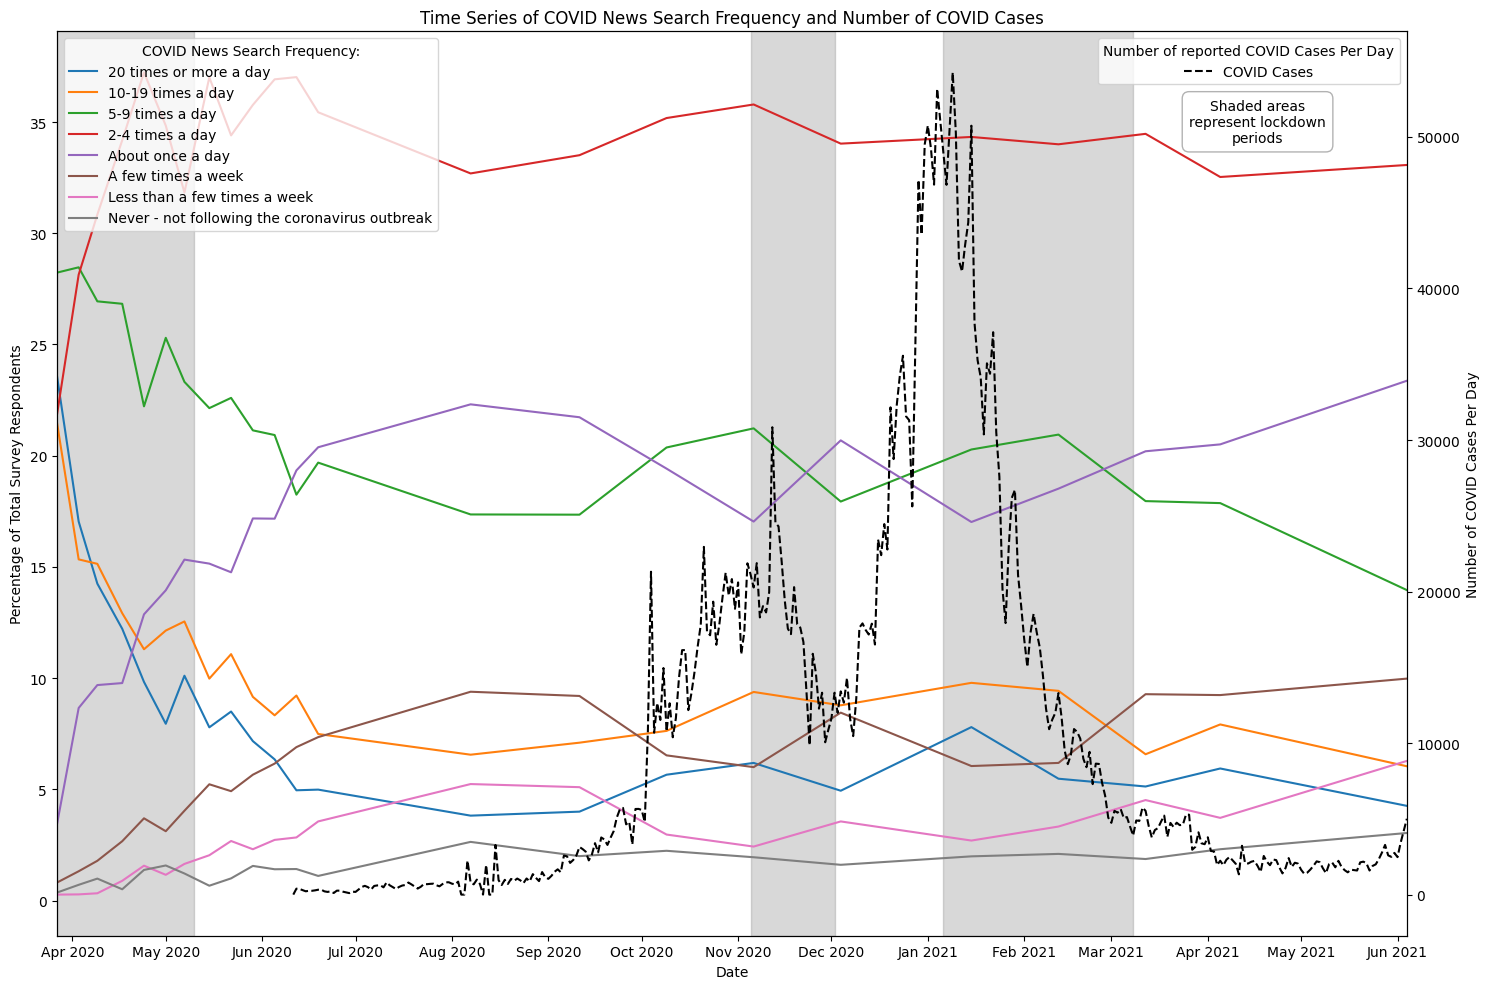

In [25]:
fig, ax1 = plt.subplots(figsize=(15, 10))

for i, category in enumerate(dataframe['response'].unique()):
    category_data = dataframe[dataframe['response'] == category]
    ax1.plot(category_data['start_date'], category_data['percentage_total_respondents'], 
             label=category, linestyle='-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Percentage of Total Survey Respondents')

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

ax1.set_xlim([dt.datetime(2020, 3, 27), dt.datetime(2021, 6, 4)])

ax2 = ax1.twinx()
ax2.plot(df_no_outliers['date'], df_no_outliers['confirmed_diff'], label='COVID Cases', linestyle='--', color='black')
ax2.set_ylabel('Number of COVID Cases Per Day')

ax1.legend(title='COVID News Search Frequency:', loc='upper left')
ax2.legend(title='Number of reported COVID Cases Per Day', loc='upper right')

lockdown_periods = [
    ('2020-03-27', '2020-05-10', '1st Lockdown'),
    ('2020-11-05', '2020-12-02', '2nd Lockdown'),
    ('2021-01-06', '2021-03-08', '3rd Lockdown'),
]
    
for start_date, end_date, label in lockdown_periods:
    ax1.axvspan(
        dt.datetime.strptime(start_date, '%Y-%m-%d'), 
        dt.datetime.strptime(end_date, '%Y-%m-%d'), 
        color='gray', alpha=0.3, label=label
    )

plt.text(
    dt.datetime(2021, 4, 17), 51000,
    'Shaded areas\nrepresent lockdown\nperiods',
    fontsize=10,
    color='black',
    ha='center',
    va='center',
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        boxstyle='round,pad=0.5', 
        alpha=0.3
    )
)

plt.title('Time Series of COVID News Search Frequency and Number of COVID Cases')

plt.tight_layout()

plt.savefig('3_final_figures/misinformation_ofcom/frequency_of_sourcing_news/misinformation_frequency_of_news_covid_timeseries.png', dpi=300)

plt.show()

# 4. Sources used to get information about the coronavirus outbreak


In [26]:
sources_used_dataframe = ofcom_dataframes['sources_used_to_get_infonews_about_coronavirus_outbreak_in_last_week']

### As I will be plotting many time series for the graph, I made a function to return the weighted percentages:

In [27]:
def calculate_percentage(dataframe):
    
    weighted_bases = dataframe[dataframe['response'] == 'Weighted base'][['start_date', 'total']].reset_index(drop=True)

    def get_total(start_date):
        lookup_dict = weighted_bases.set_index('start_date')['total'].to_dict()
        return lookup_dict.get(start_date)

    dataframe['weighted_base'] = dataframe['start_date'].map(get_total)

    dataframe['percentage_total_respondents'] = round((dataframe['total'] / dataframe['weighted_base']) * 100, 2)

    return dataframe[['start_date', 'response', 'percentage_total_respondents']]

In [28]:
sources_used_dataframe = calculate_percentage(sources_used_dataframe)

In [29]:
# sources_used_dataframe

In [30]:
sources_used_dataframe = sources_used_dataframe[~sources_used_dataframe['response'].isin(['Unweighted base', 'NET: At least once a day', 'Weighted base'])]

### From the response categories (uncomment) I have selected a few broad categories of interest for different plots

In [31]:
# sources_used_dataframe['response'].unique()

In [32]:
local_news = [
    "Local sources across TV, radio and online",
    "Family and friends directly",
    "Community radio",
    "People in your local area/neighbourhood"
]

In [33]:
newspapers = [
        '“Red-top tabloids” such as The Sun or Daily Mirror ( printed )',
       '“Red-top tabloids” such as The Sun or Mirror ( online )',
       '“Broadsheets” such as The Times or Guardian',
       '“Broadsheets” such as The Times or Guardian ( online )',
       '“Mid-market tabloids” such as The Daily Mail or Daily Express ( printed )',
       '“Mid-market tabloids” such as MailOnline or Express ( online )'
]

#### After playing with the plotting function, I noted that the response changed from Direct from Government website/ email/ text/ post to Direct from UK Government website/ email/ text/ post

In [34]:
official_sources = [
    "Direct from Local health service website/ email/ text/ post",
    "Direct from NHS website/ email/ text/ post",
    "Direct from World Health Organisation (WHO) website/ email/ text/ post",
    "Direct from UK Government website/ email/ text/ post",
    "Direct from Local council website/ email/ text/ post",
    "Official scientists"
]

In [35]:
sources_used_dataframe.loc[sources_used_dataframe['response'] == "Direct from Government website/ email/ text/ post", 'response'] = "Direct from UK Government website/ email/ text/ post"

In [36]:
television = [
    'BBC - TV',
    'Channel 4',
    'Channel 5',
    'ITV'
]

In [37]:
social_media = [
    "NET: Social Media",
    "NET: Facebook (Facebook and Facebook Messenger)",
    "NET: WhatsApp (WhatsApp and WhatsApp groups)",
    "Instagram",
    "Twitter",
    "YouTube",
    "Snapchat",
]

## I created a function to plot similar Time Series graphs to Save time and decide which Pplots are most relevant

In [38]:
def plot_time_series(dataframe_1, dataframe_2, categories, filename, plot_title, x_title, y_title, y2_title, legend_1_title, legend_2_title, min_date, max_date):
    fig, ax1 = plt.subplots(figsize=(15, 10))

    for i, category in enumerate(categories):
        category_data = dataframe_1[dataframe_1['response'] == category]
        ax1.plot(category_data['start_date'], category_data['percentage_total_respondents'], 
                 label=category, linestyle='-')

    ax1.set_xlabel(f'{x_title}')
    ax1.set_ylabel(f'{y_title}')

    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    ax2 = ax1.twinx()
    ax2.plot(dataframe_2['date'], dataframe_2['confirmed_diff'], label=f'{y2_title}', linestyle='--', color='black')
    ax2.set_ylabel('Number of COVID Cases Per Day')

    ax1.legend(title=f'{legend_1_title}', loc='upper left')
    ax2.legend(title=f'{legend_2_title}', loc='upper right')

    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.set_xlim([min_date, max_date])
    
    lockdown_periods = [
        ('2020-03-27', '2020-05-10', '1st Lockdown'),
        ('2020-11-05', '2020-12-02', '2nd Lockdown'),
        ('2021-01-06', '2021-03-08', '3rd Lockdown'),
    ]

    for start_date, end_date, label in lockdown_periods:
        ax1.axvspan(
            dt.datetime.strptime(start_date, '%Y-%m-%d'), 
            dt.datetime.strptime(end_date, '%Y-%m-%d'), 
            color='gray', alpha=0.3, label=label
        )

    plt.text(
    dt.datetime (2021, 4, 17), 51000,
    'Shaded areas\nrepresent lockdown\nperiods',
    fontsize=10,
    color='black',
    ha='center',
    va='center',
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        boxstyle='round,pad=0.5', 
        alpha=0.3
    )
)

    plt.title(f'{plot_title}')
    plt.tight_layout()

    plt.savefig(f'{filename}.png', dpi=300)

#### I set the root for the file path for the news_source_figures

In [39]:
root_image_path = '3_final_figures/misinformation_ofcom/news_sources_figures/'

## I also create two functions to filter the dataframe and return minimum and maximum date

In [40]:
def filter_dataframe(dataframe, category):
    copy_dataframe = dataframe.copy()
    copy_dataframe = copy_dataframe[copy_dataframe['response'].isin(category)]
    return copy_dataframe

In [41]:
def return_min_max_date(dataframe):
    min_date = dataframe['start_date'].min()
    max_date = dataframe['start_date'].max()
    return min_date, max_date

## Plotting the newspaper sources dataframe

In [42]:
newspaper_dataframe = filter_dataframe(sources_used_dataframe, newspapers)

In [43]:
min_date, max_date = return_min_max_date(newspaper_dataframe)

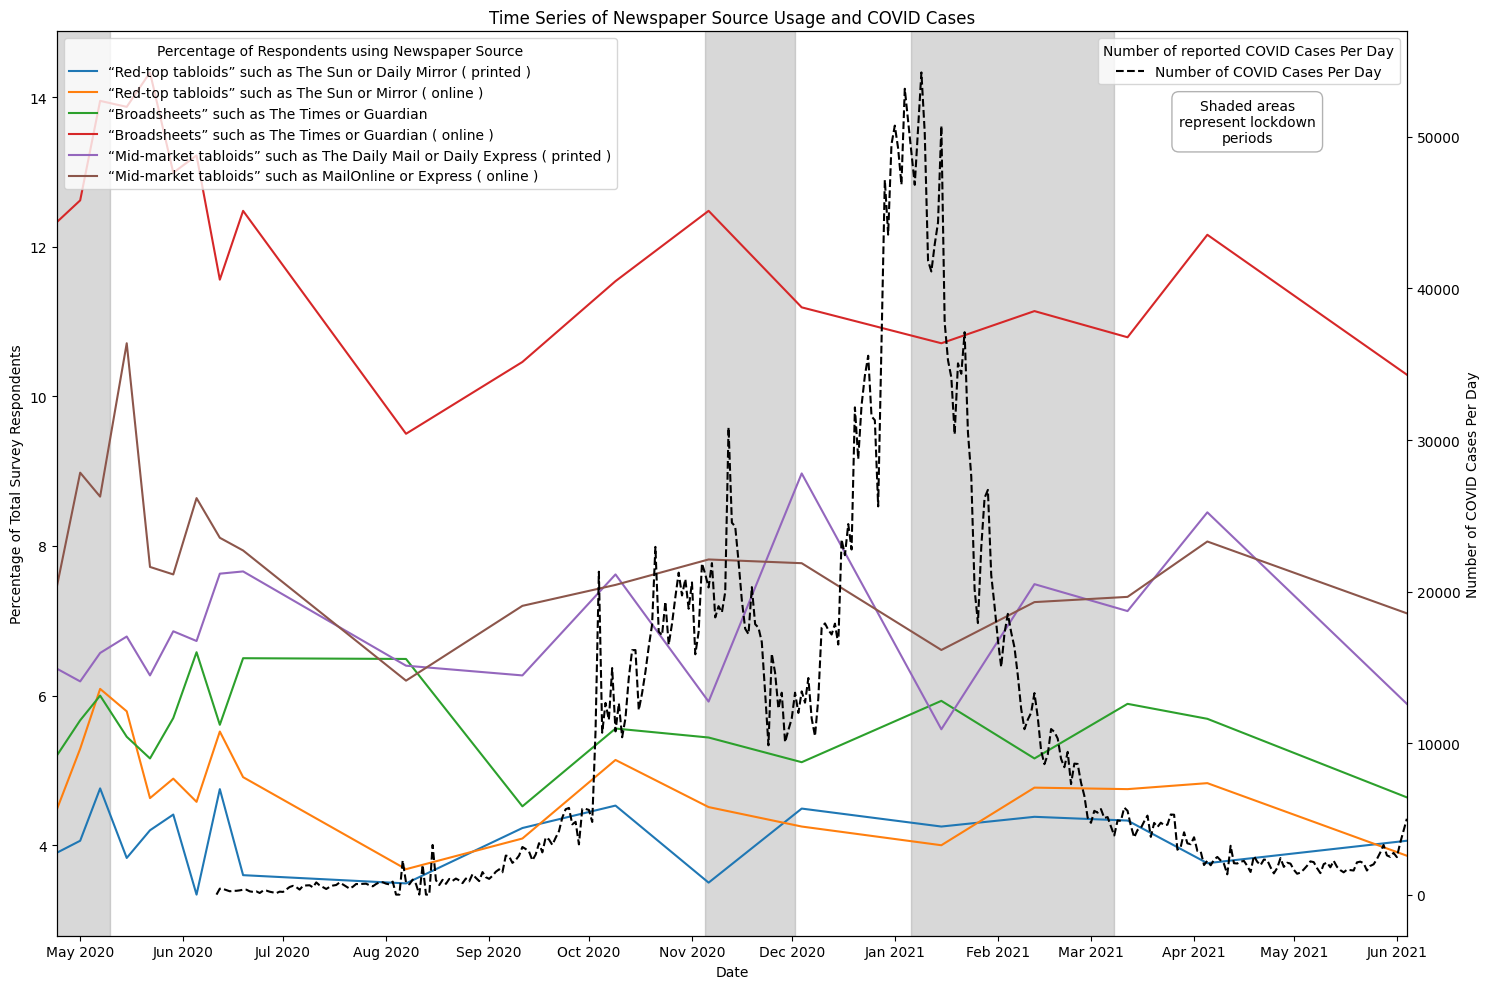

In [44]:
plot_time_series(dataframe_1 = newspaper_dataframe, dataframe_2 = df_no_outliers, categories = newspapers, plot_title = 'Time Series of Newspaper Source Usage and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents using Newspaper Source', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}newspaper_sources_time_series', min_date = min_date, max_date = max_date)

## Plotting the official sources data

In [45]:
official_sources_dataframe = filter_dataframe(sources_used_dataframe, official_sources)

In [46]:
min_date, max_date = return_min_max_date(official_sources_dataframe)

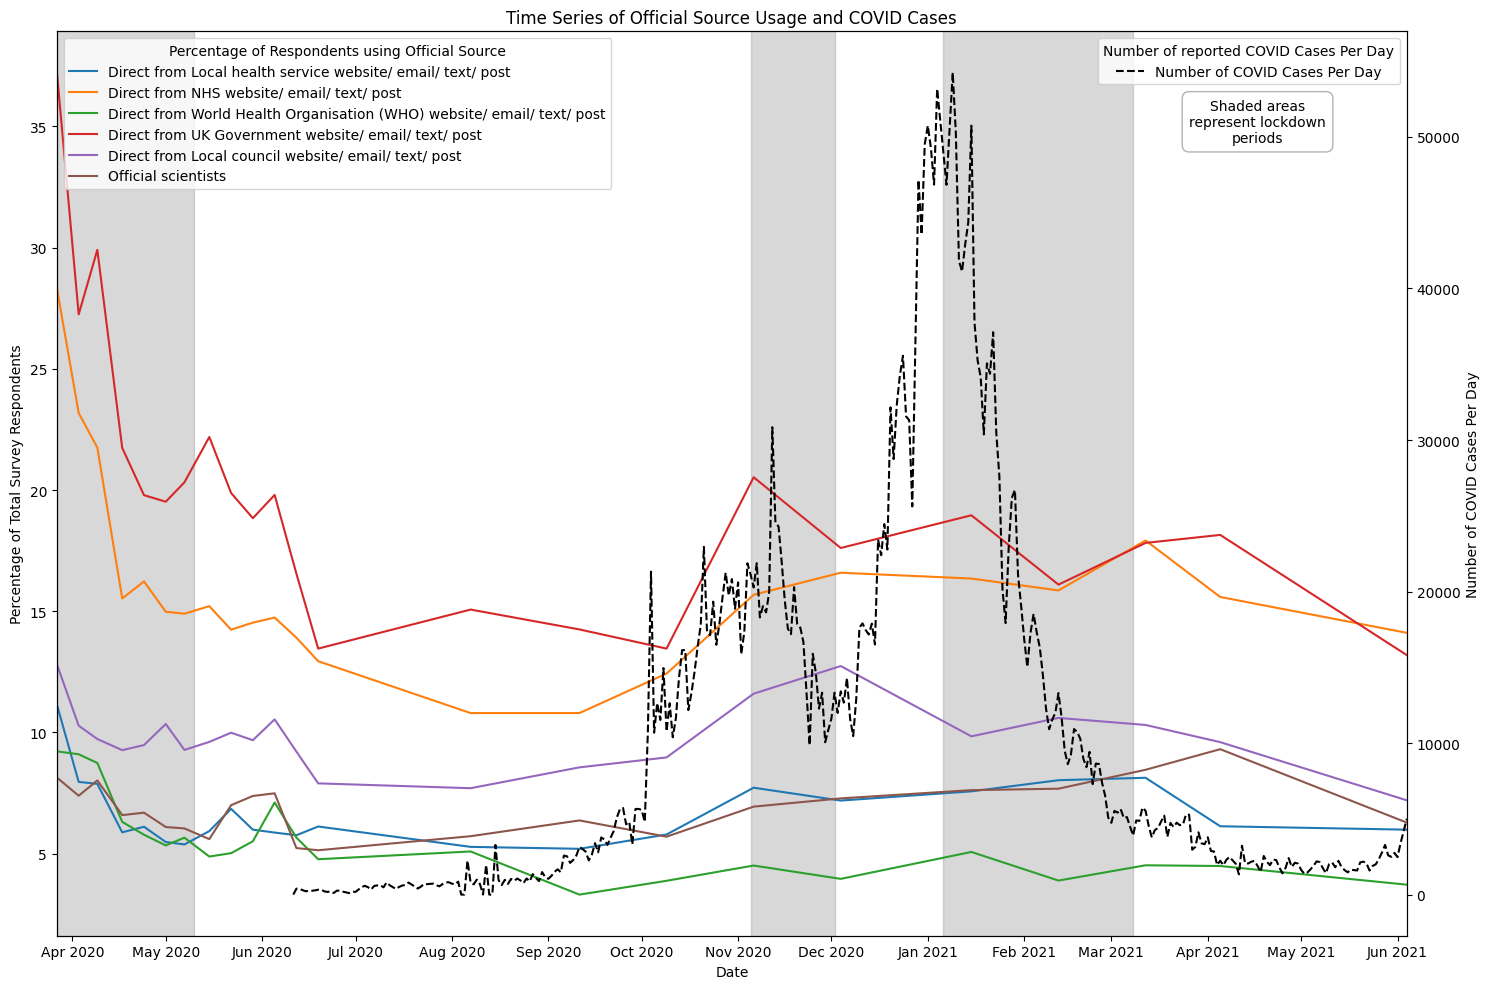

In [47]:
plot_time_series(dataframe_1 = official_sources_dataframe, dataframe_2 = df_no_outliers, categories = official_sources, plot_title = 'Time Series of Official Source Usage and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents using Official Source', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}official_sources_time_series', min_date = min_date, max_date = max_date)

## Plotting the television sources data

In [48]:
television_sources_dataframe = filter_dataframe(sources_used_dataframe, television)

In [49]:
min_date, max_date = return_min_max_date(television_sources_dataframe)

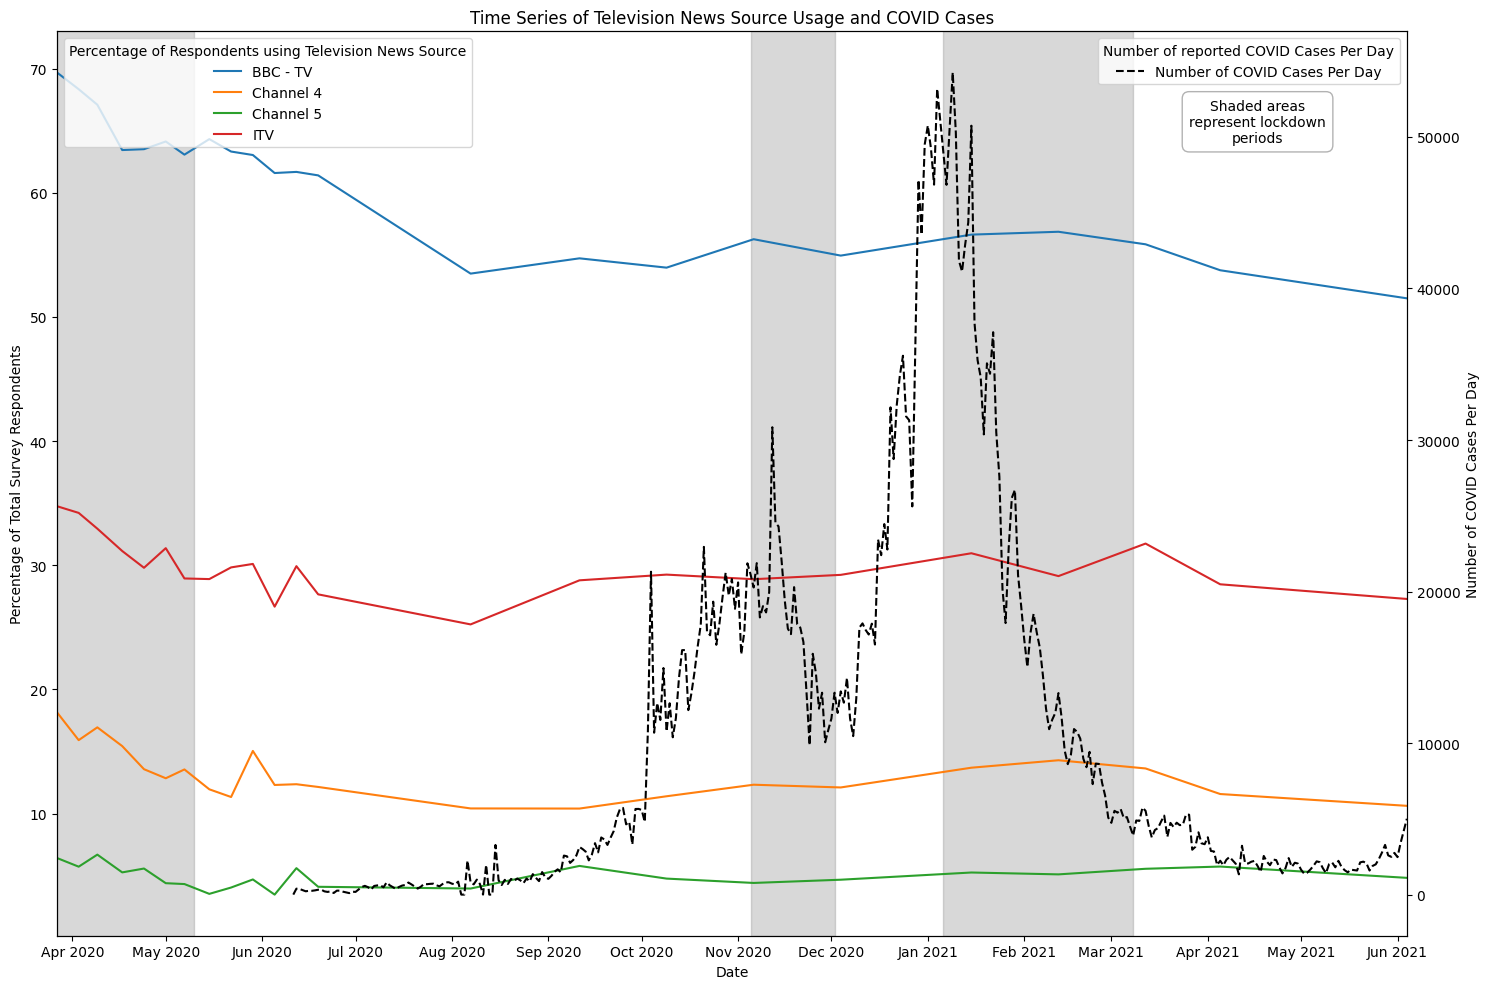

In [50]:
plot_time_series(dataframe_1 = television_sources_dataframe, dataframe_2 = df_no_outliers, categories = television, plot_title = 'Time Series of Television News Source Usage and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents using Television News Source', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}television_time_series', min_date = min_date, max_date = max_date)

## Plotting the social media source usage

In [51]:
social_media_dataframe = filter_dataframe(sources_used_dataframe, social_media)

In [52]:
min_date, max_date = return_min_max_date(social_media_dataframe)

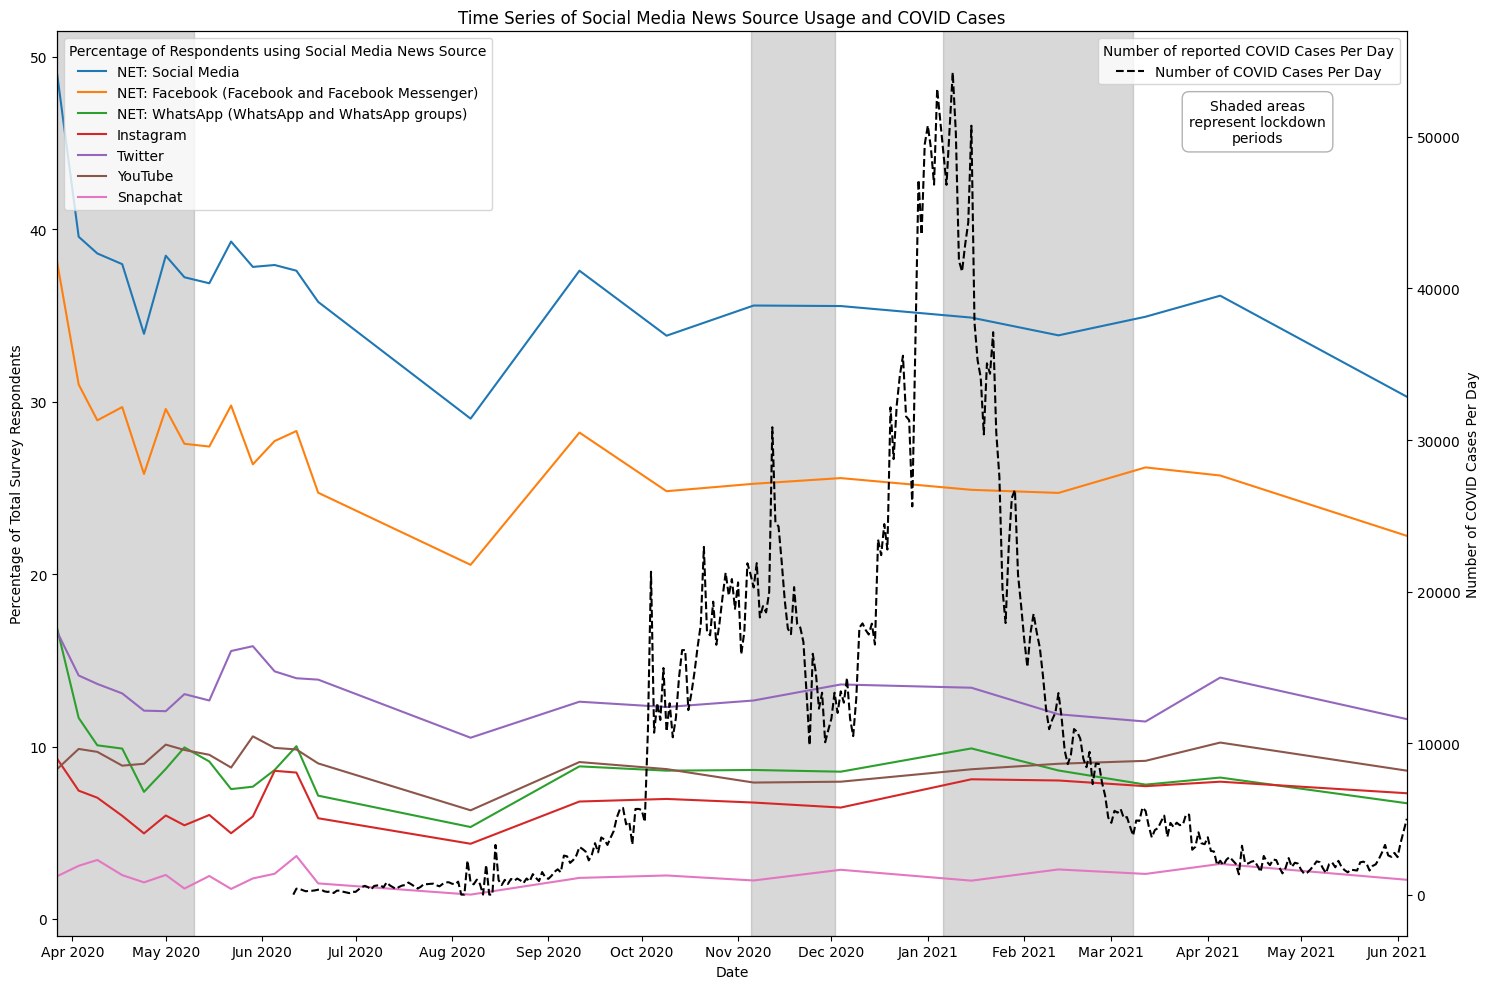

In [53]:
plot_time_series(dataframe_1 = social_media_dataframe, dataframe_2 = df_no_outliers, categories = social_media, plot_title = 'Time Series of Social Media News Source Usage and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents using Social Media News Source', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}social_media_time_series', min_date = min_date, max_date = max_date)

## Plotting the local news source usage


In [54]:
local_news_dataframe = filter_dataframe(sources_used_dataframe, local_news)

In [55]:
min_date, max_date = return_min_max_date(local_news_dataframe)

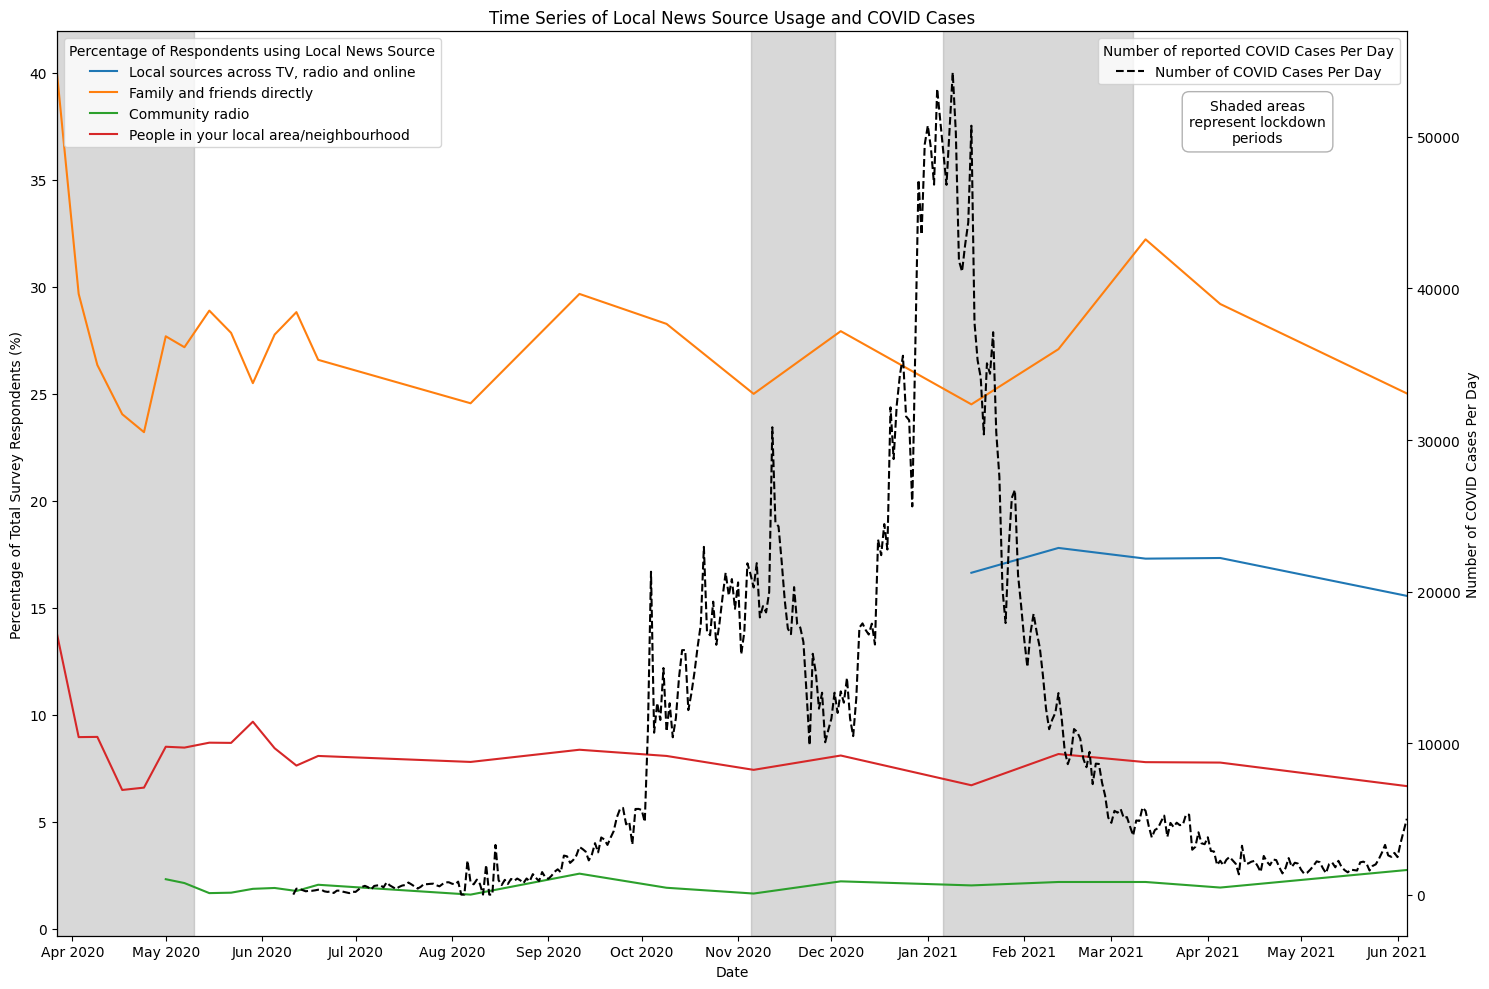

In [56]:
plot_time_series(dataframe_1 = local_news_dataframe, dataframe_2 = df_no_outliers, categories = local_news, plot_title = 'Time Series of Local News Source Usage and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents using Local News Source', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}local_news_time_series', min_date = min_date, max_date = max_date)

# 5. Most important data source

In [57]:
most_important_source_dataframe = ofcom_dataframes['most_important_source_used_in_last_week']

In [58]:
most_important_source_dataframe = calculate_percentage(most_important_source_dataframe)

In [59]:
most_important_source_dataframe = most_important_source_dataframe[~most_important_source_dataframe['response'].isin(['Unweighted base', 'NET: At least once a day', 'Weighted base'])]

## Local News information sources

In [60]:
local_news_dataframe = filter_dataframe(most_important_source_dataframe, local_news)

In [61]:
min_date, max_date = return_min_max_date(local_news_dataframe)

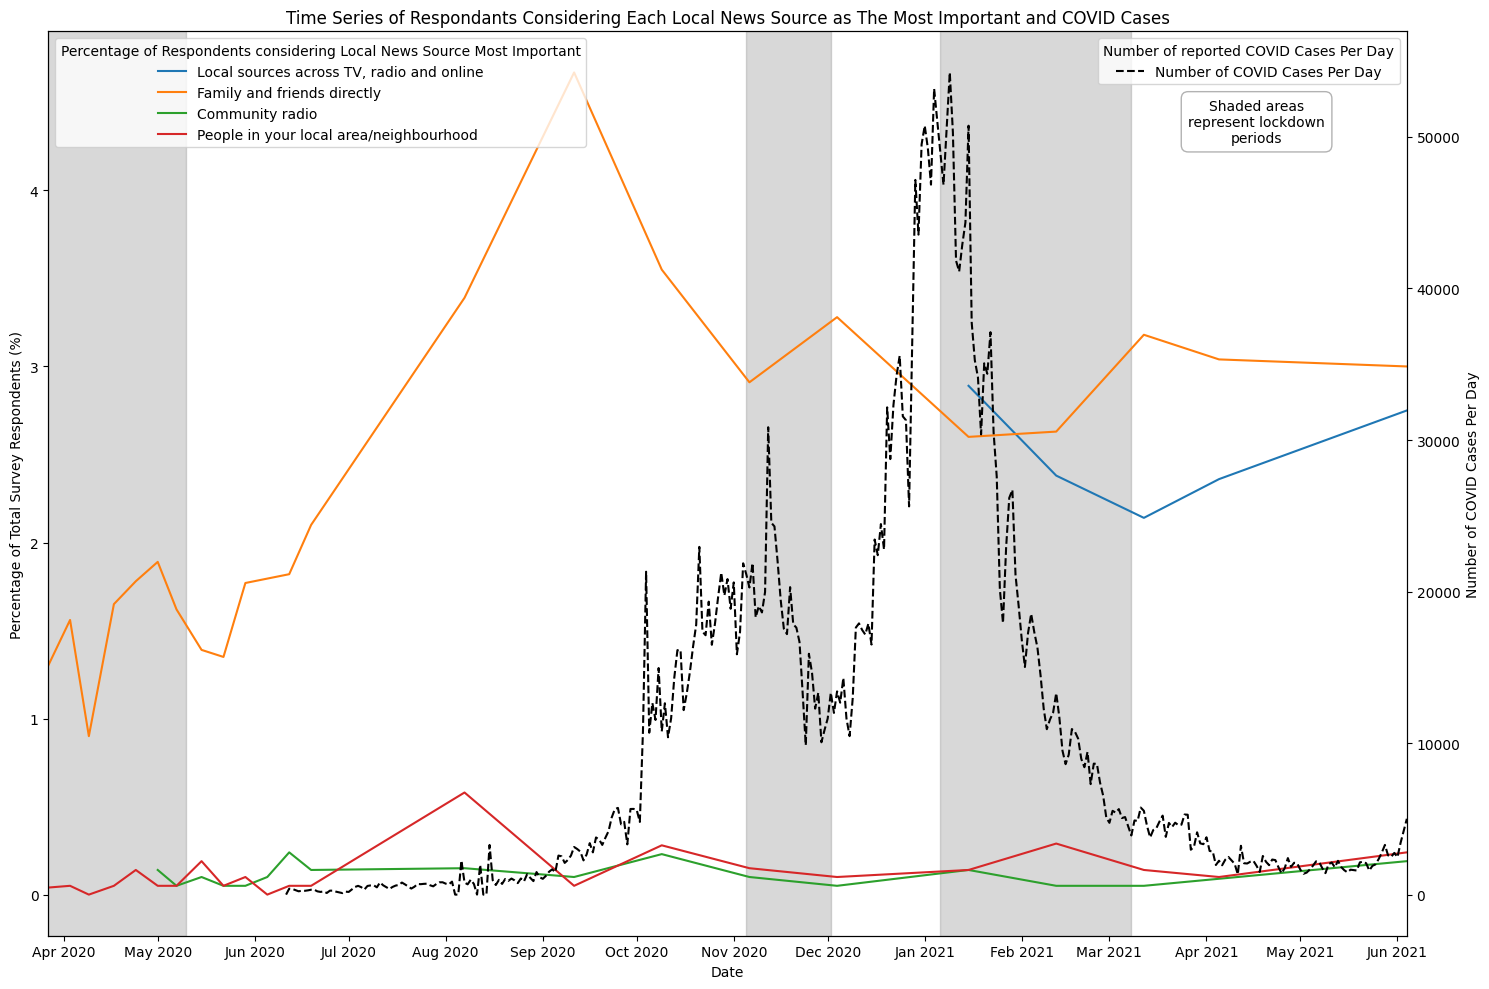

In [62]:
plot_time_series(dataframe_1 = local_news_dataframe, dataframe_2 = df_no_outliers, categories = local_news, plot_title = 'Time Series of Respondants Considering Each Local News Source as The Most Important and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents considering Local News Source Most Important', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}most_important_local_news_time_series', min_date = min_date, max_date = max_date)

## Newspaper information sources

In [63]:
newspapers_dataframe = filter_dataframe(most_important_source_dataframe, newspapers)

In [64]:
min_date, max_date = return_min_max_date(newspapers_dataframe)

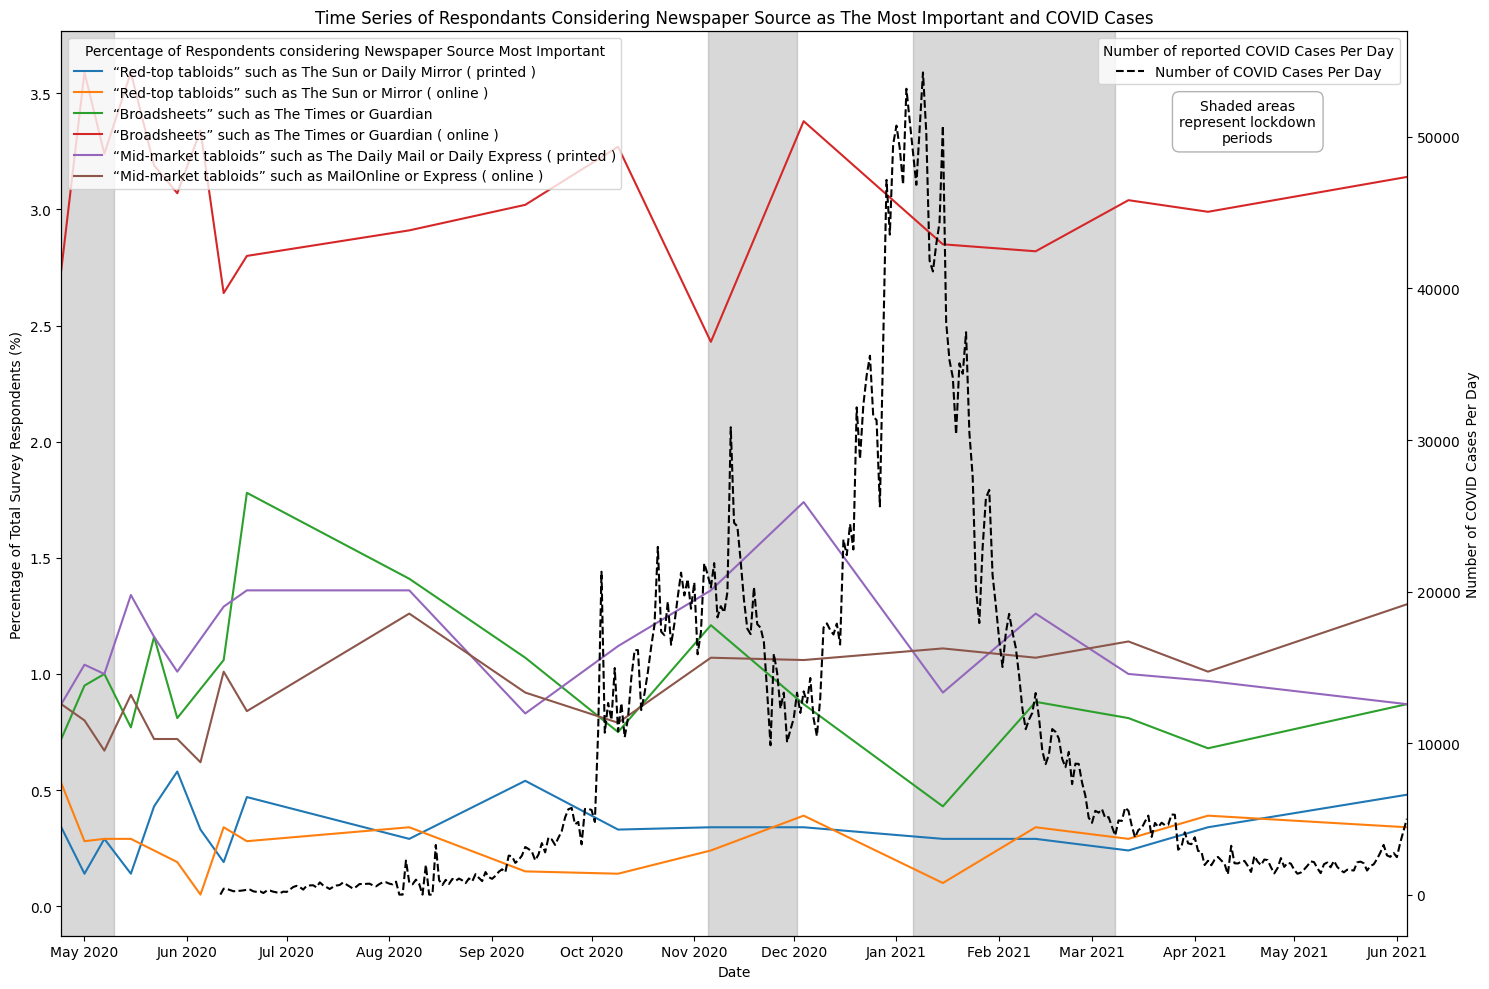

In [65]:
plot_time_series(dataframe_1 = newspapers_dataframe, dataframe_2 = df_no_outliers, categories = newspapers, plot_title = 'Time Series of Respondants Considering Newspaper Source as The Most Important and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents considering Newspaper Source Most Important', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}most_important_newspaper_time_series', min_date = min_date, max_date = max_date)

## Official information sources

In [66]:
official_sources_dataframe = filter_dataframe(most_important_source_dataframe, official_sources)

In [67]:
min_date, max_date = return_min_max_date(official_sources_dataframe)

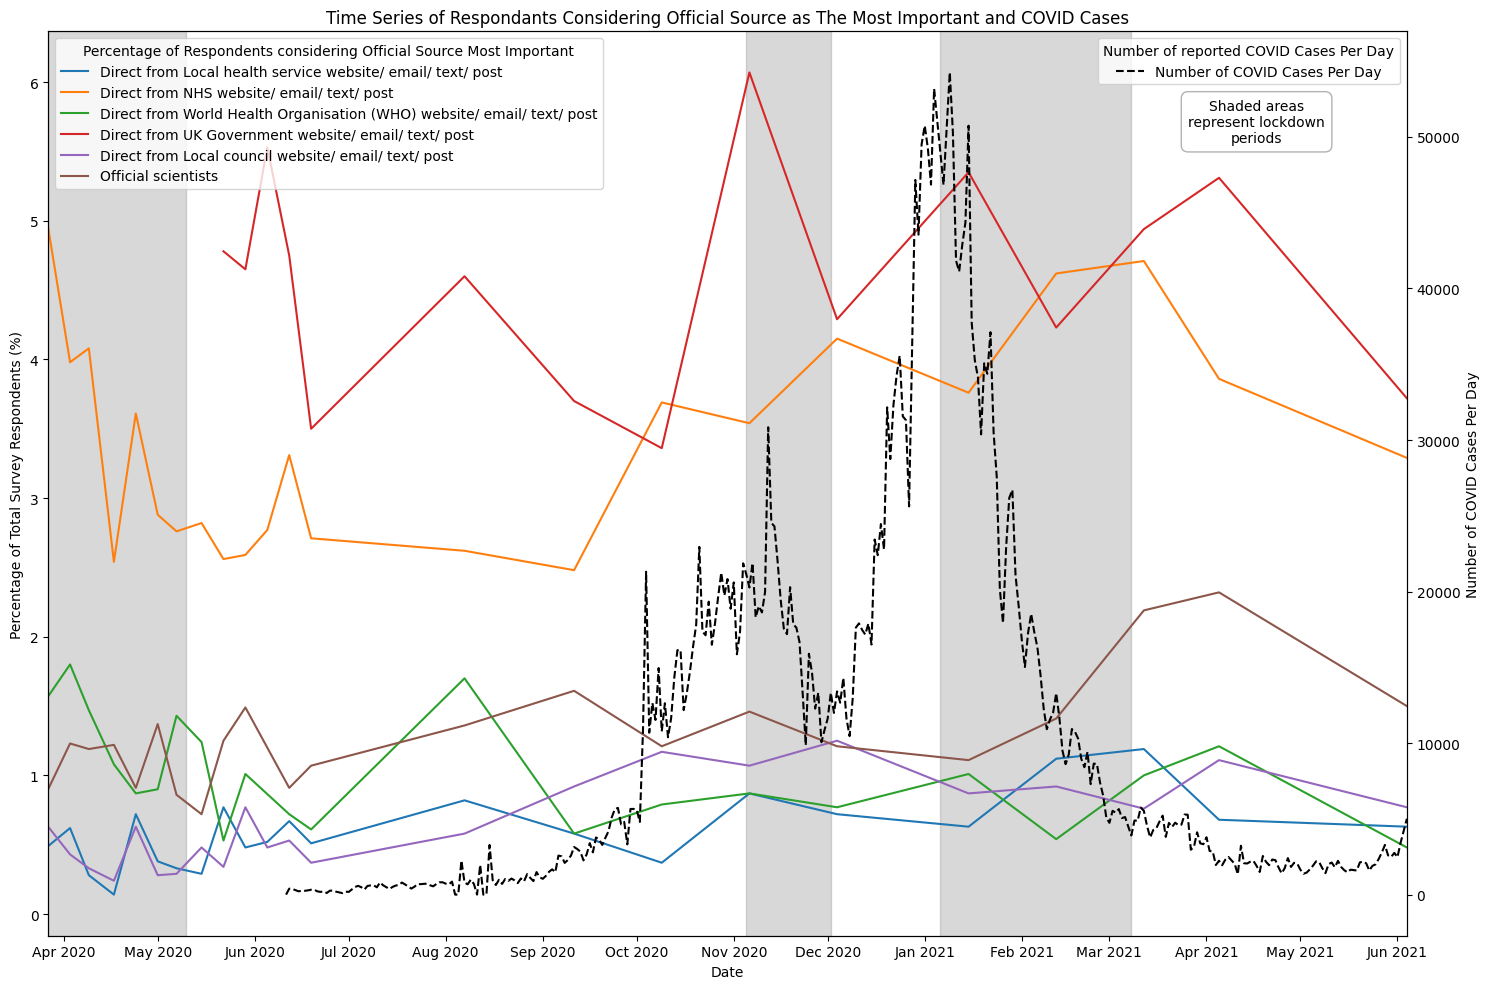

In [68]:
plot_time_series(dataframe_1 = official_sources_dataframe, dataframe_2 = df_no_outliers, categories = official_sources, plot_title = 'Time Series of Respondants Considering Official Source as The Most Important and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents considering Official Source Most Important', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}most_important_official_source_time_series', min_date = min_date, max_date = max_date)

## Television Information Sources

In [69]:
television_sources_dataframe = filter_dataframe(most_important_source_dataframe, television)

In [70]:
min_date, max_date = return_min_max_date(television_sources_dataframe)

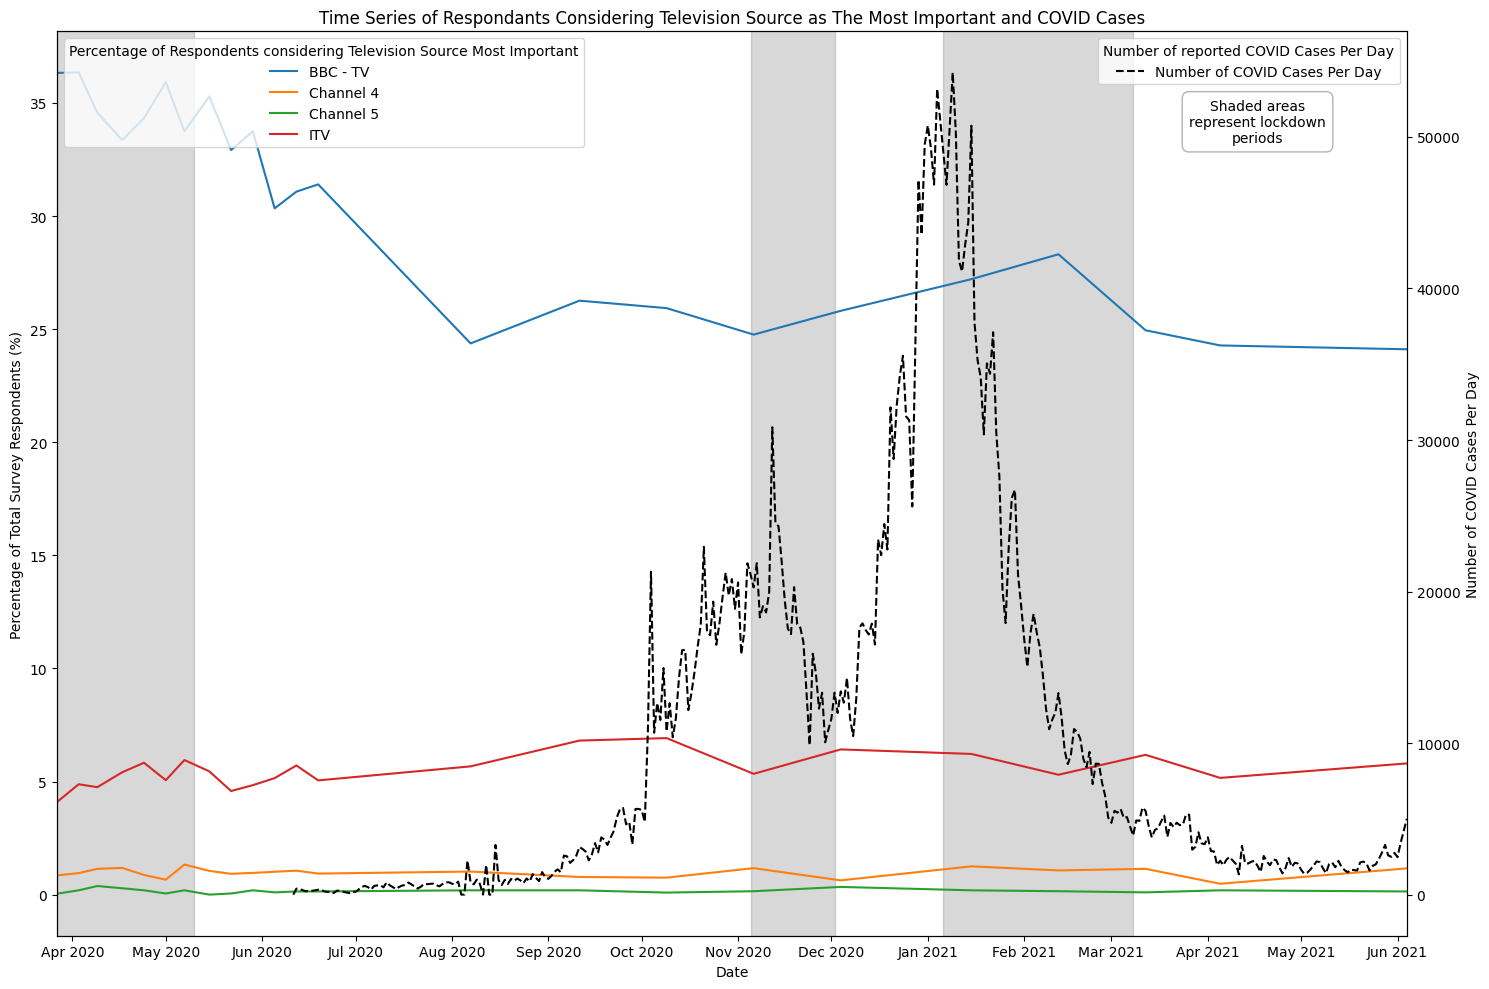

In [71]:
plot_time_series(dataframe_1 = television_sources_dataframe, dataframe_2 = df_no_outliers, categories = television, plot_title = 'Time Series of Respondants Considering Television Source as The Most Important and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents considering Television Source Most Important', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}most_important_official_source_time_series', min_date = min_date, max_date = max_date)

## Social Media

In [72]:
social_media_sources_dataframe = filter_dataframe(most_important_source_dataframe, social_media)

In [73]:
min_date, max_date = return_min_max_date(social_media_sources_dataframe)

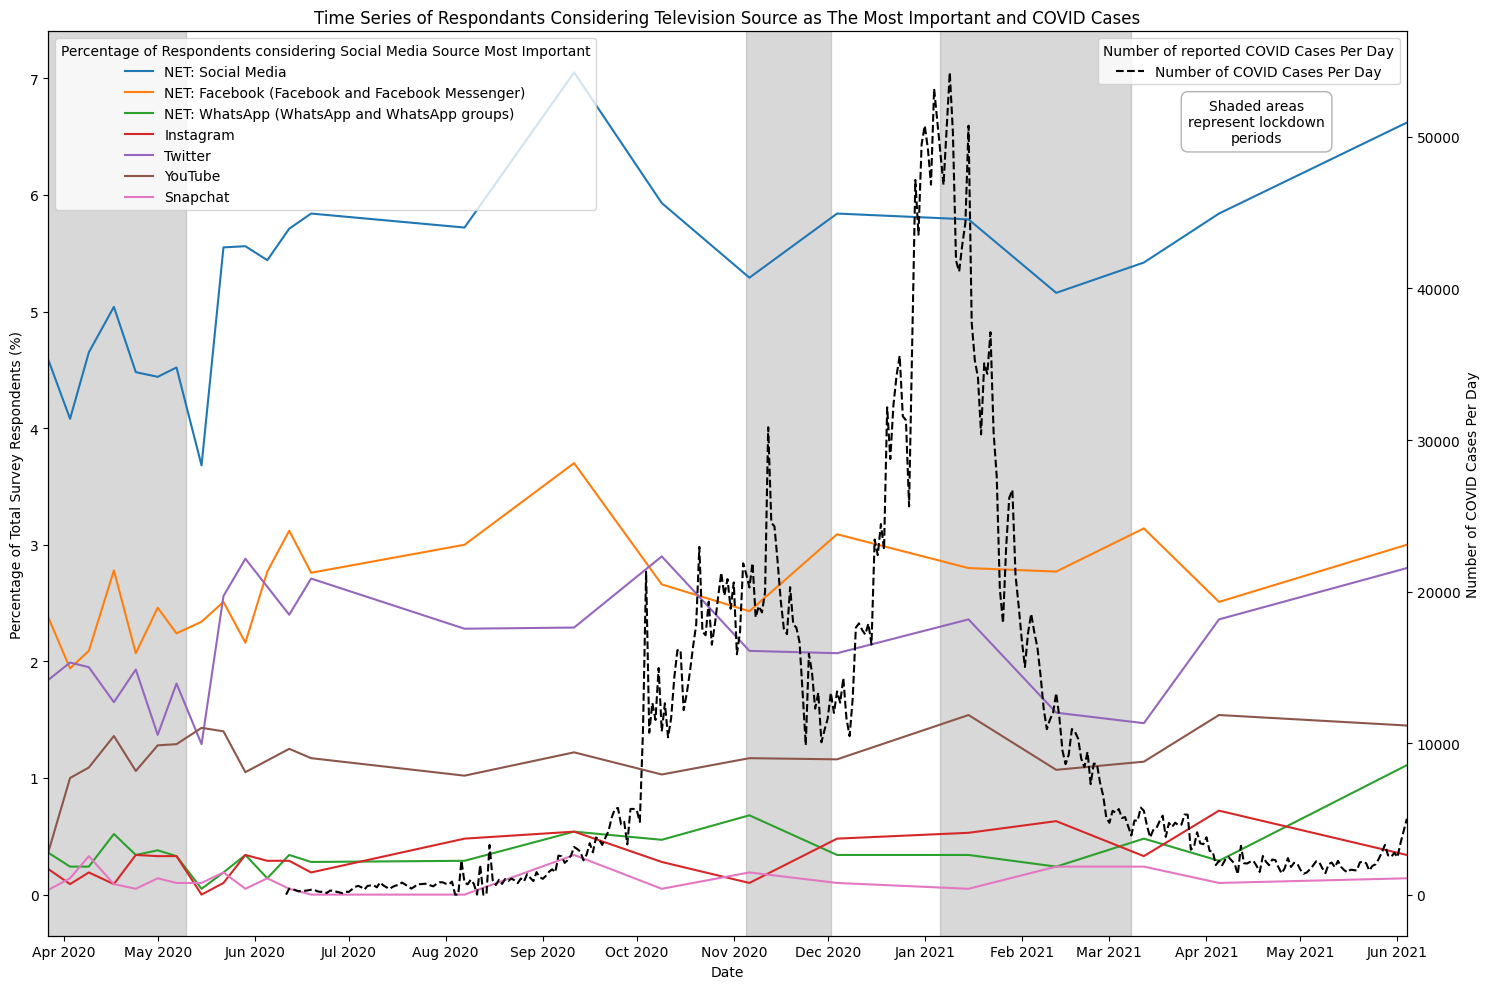

In [74]:
plot_time_series(dataframe_1 = social_media_sources_dataframe, dataframe_2 = df_no_outliers, categories = social_media, plot_title = 'Time Series of Respondants Considering Television Source as The Most Important and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents considering Social Media Source Most Important', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}most_important_social_media_source_time_series', min_date = min_date, max_date = max_date)

## 6. Trust in the news

In [75]:
trust_in_source_dataframe = ofcom_dataframes['trust_in_the_sources_for_informationnews_about_coronavirus_used_in_last_week']

In [76]:
trust_in_source_dataframe = calculate_percentage(trust_in_source_dataframe)

In [77]:
trust_in_source_dataframe = trust_in_source_dataframe[~trust_in_source_dataframe['response'].isin(['Unweighted base', 'Weighted base', 'NET: Trust', 'NET: Do not trust', 'Mean', 'Standard deviation Standard error'])]

In [78]:
min_date, max_date = return_min_max_date(trust_in_source_dataframe)

In [79]:
categories = trust_in_source_dataframe['response'].unique()

In [80]:
categories

array(['5 - Trust completely', '4', '3', '2', '1 - Do not trust at all'],
      dtype=object)

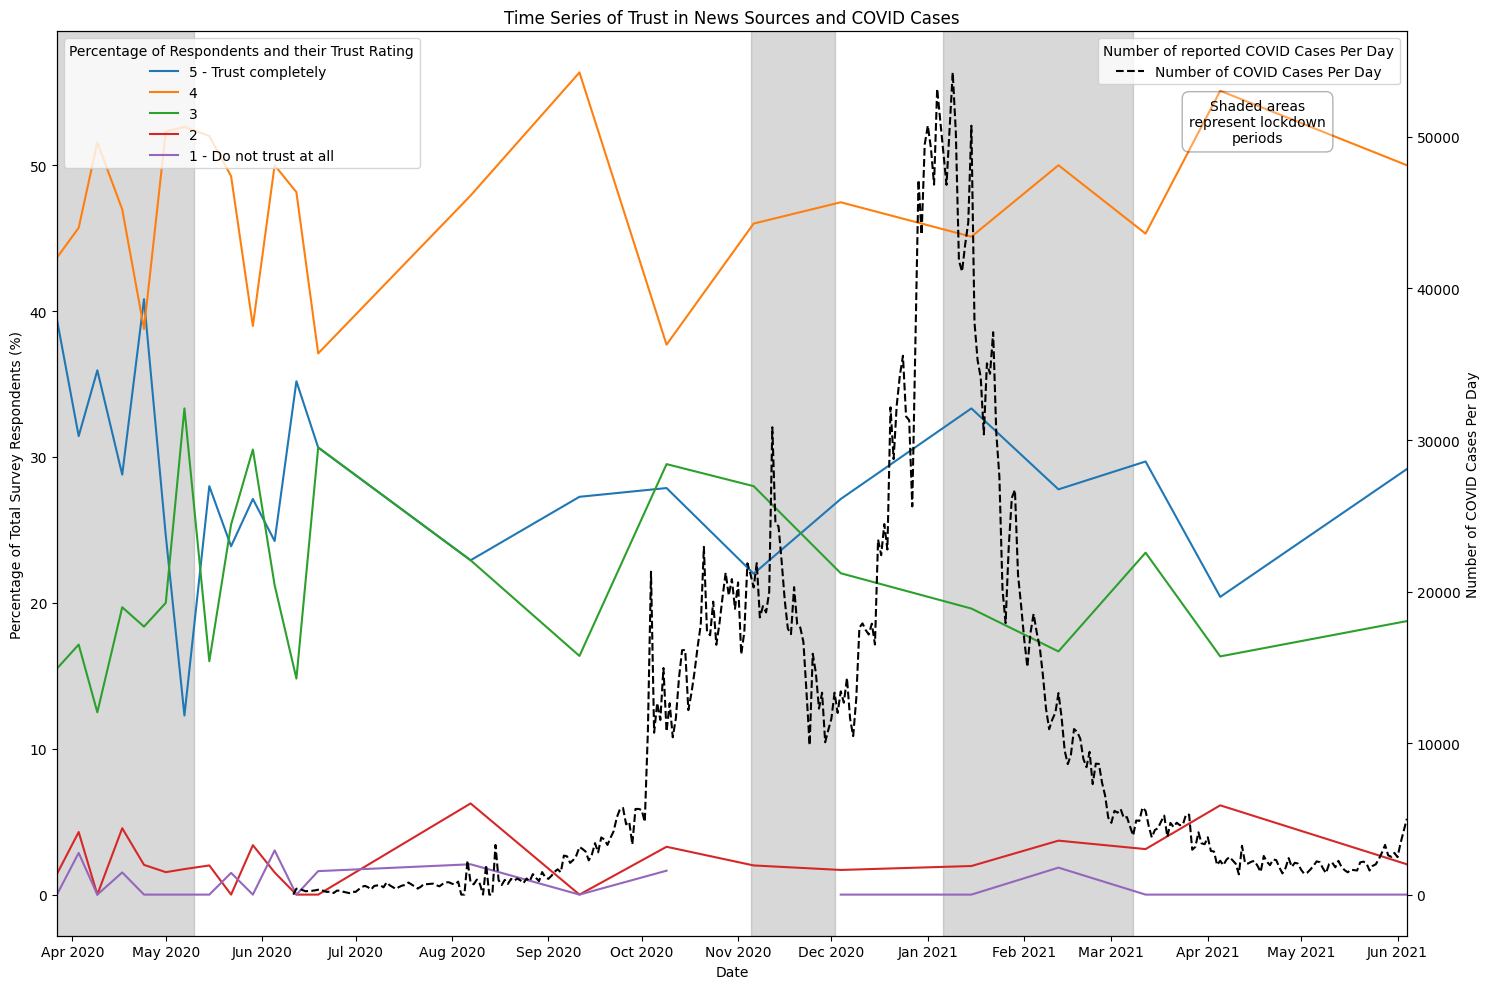

In [81]:
plot_time_series(dataframe_1 = trust_in_source_dataframe, dataframe_2 = df_no_outliers, categories = categories, plot_title = 'Time Series of Trust in News Sources and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents and their Trust Rating', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}trust_in_news_source_time_series', min_date = min_date, max_date = max_date)

## 6. Misinformation 
### Exposure to misinformation over the pandemic

In [82]:
exposure_fake_news = ofcom_dataframes['whether_came_across_informationnews_about_coronavirus_that_you_think_has_been_false_or_misleading_in_last_week']

In [83]:
exposure_fake_news = calculate_percentage(exposure_fake_news)

In [84]:
exposure_fake_news = exposure_fake_news[~exposure_fake_news['response'].isin(['Unweighted base', 'Weighted base'])]

In [85]:
categories = exposure_fake_news['response'].unique()

In [86]:
min_date, max_date = return_min_max_date(exposure_fake_news)

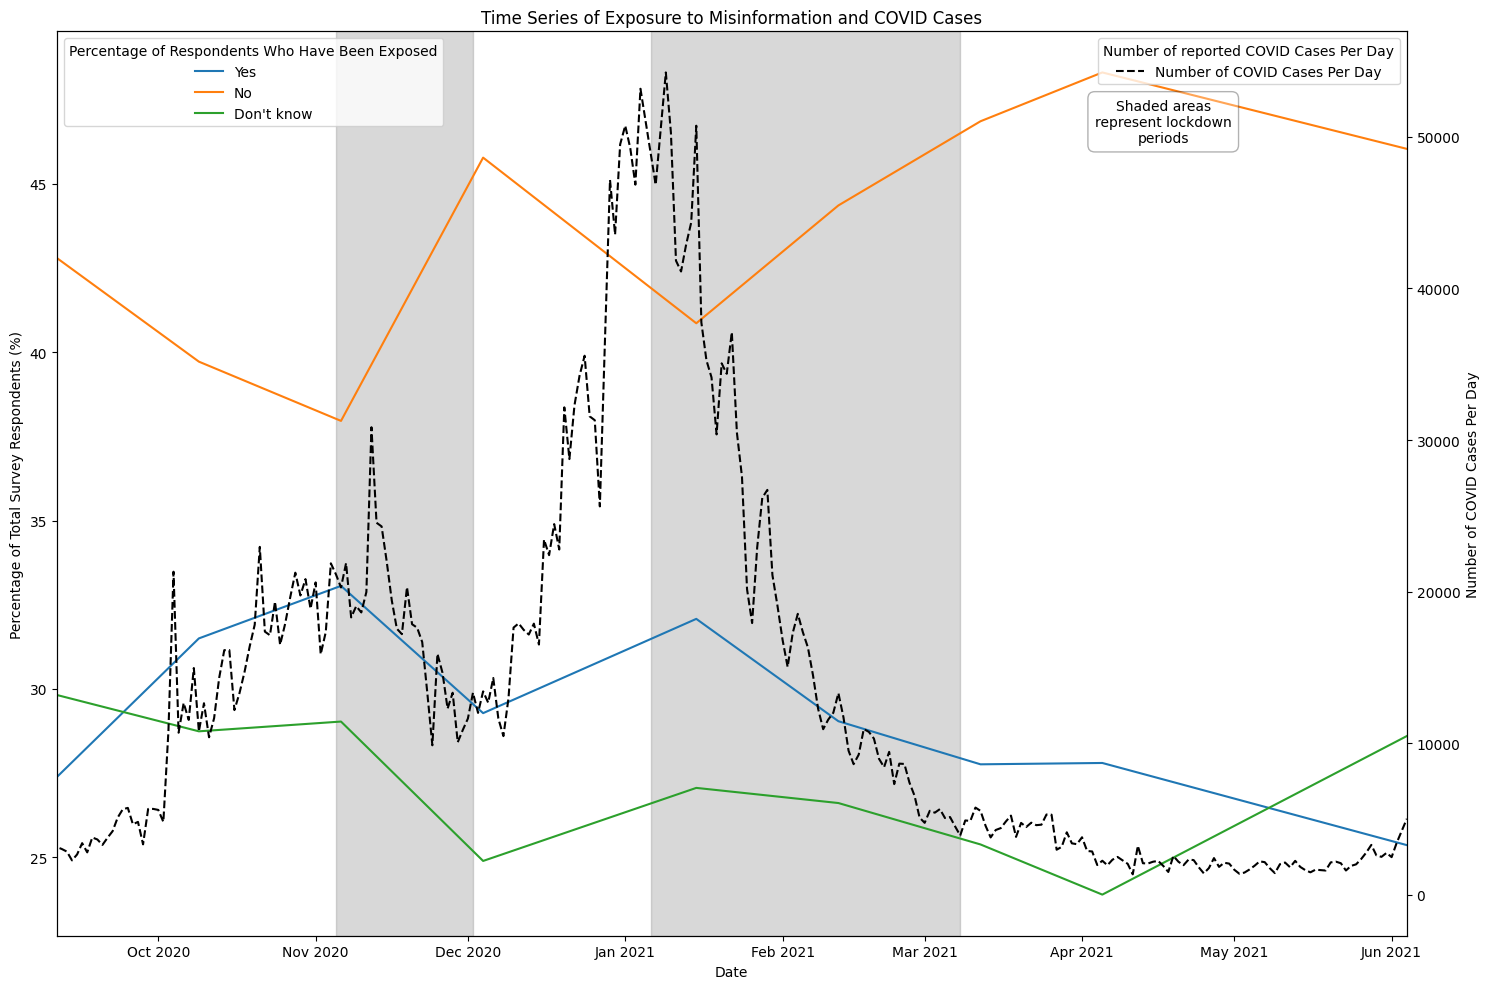

In [87]:
plot_time_series(dataframe_1 = exposure_fake_news, dataframe_2 = df_no_outliers, categories = categories, plot_title = 'Time Series of Exposure to Misinformation and COVID Cases', x_title = 'Date', y_title = 'Percentage of Total Survey Respondents (%)', y2_title = 'Number of COVID Cases Per Day', legend_1_title = 'Percentage of Respondents Who Have Been Exposed', legend_2_title = 'Number of reported COVID Cases Per Day', filename = f'{root_image_path}exposure_to_misinformation_time_series', min_date = min_date, max_date = max_date)

### How misinformation has been reported

In [88]:
ofcom_dataframes['how_theory_that_the_origin_or_cause_of_coronavirus_is_in_some_way_linked_to_5g_technology_has_been_reported']

start_date    end_date                                           question  \
0   2020-11-06  2020-11-08  how_theory_that_the_origin_or_cause_of_coronav...   
1   2020-11-06  2020-11-08  how_theory_that_the_origin_or_cause_of_coronav...   
2   2020-11-06  2020-11-08  how_theory_that_the_origin_or_cause_of_coronav...   
3   2020-11-06  2020-11-08  how_theory_that_the_origin_or_cause_of_coronav...   
4   2020-11-06  2020-11-08  how_theory_that_the_origin_or_cause_of_coronav...   
5   2020-12-04  2020-12-06  how_theory_that_the_origin_or_cause_of_coronav...   
6   2020-12-04  2020-12-06  how_theory_that_the_origin_or_cause_of_coronav...   
7   2020-12-04  2020-12-06  how_theory_that_the_origin_or_cause_of_coronav...   
8   2020-12-04  2020-12-06  how_theory_that_the_origin_or_cause_of_coronav...   
9   2020-12-04  2020-12-06  how_theory_that_the_origin_or_cause_of_coronav...   
10  2021-01-15  2021-01-17  how_theory_that_the_origin_or_cause_of_coronav...   
11  2021-01-15  2021-01-17  how_theory_that_the_origin_or_cause_of_coronav...   
12  2021-01-15  2021-01-17  how_theory_that_the_origin_or_cause_of_coronav...   
13  2021-01-15  2021-01-17  how_theory_that_the_origin_or_cause_of_coronav...   
14  2021-01-15  2021-01-17  how_theory_that_the_origin_or_cause_of_coronav...   
15  2021-02-12  2021-02-14  how_theory_that_the_origin_or_cause_of_coronav...   
16  2021-02-12  2021-02-14  how_theory_that_the_origin_or_cause_of_coronav...   
17  2021-02-12  2021-02-14  how_theory_that_the_origin_or_cause_of_coronav...   
18  2021-02-12  2021-02-14  how_theory_that_the_origin_or_cause_of_coronav...   
19  2021-02-12  2021-02-14  how_theory_that_the_origin_or_cause_of_coronav...   

                                  response  total  male  female  16-24  18-24  \
0                          Unweighted base    383   199     184     58     53   
1                            Weighted base    382   194     188     66     58   
2    Reported / described as a true theory    146    71      75     26     22   
3   Reported / described as a false theory    190   115      75     32     29   
4            Unclear whether true or false    110    42      67     15     14   
5   Reported / described as a false theory    163   101      63     24     23   
6    Reported / described as a true theory    115    50      65     15     15   
7            Unclear whether true or false    113    61      53     12     12   
8                          Unweighted base    348   194     154     43     42   
9                            Weighted base    338   183     155     45     43   
10                         Unweighted base    325   161     164     52     47   
11                           Weighted base    319   159     160     56     50   
12   Reported / described as a true theory    101    51      50     16     16   
13  Reported / described as a false theory    158    90      69     32     28   
14           Unclear whether true or false    110    45      64     19     17   
15  Reported / described as a false theory    146    76      70     32     29   
16                         Unweighted base    283   139     144     48     44   
17                           Weighted base    290   149     140     55     50   
18   Reported / described as a true theory    108    55      53     23     20   
19           Unclear whether true or false     91    41      49     13     11   

    25-34  ...  yorkshire_&_humberside  west_midlands  east_midlands  wales  \
0      59  ...                      36             26             27     15   
1      61  ...                      39             28             24     14   
2      29  ...                      13             15              6      3   
3      26  ...                      18             12             14     10   
4      23  ...                      12             11              7      3   
5      39  ...                       9             11              9     13   
6      28  ...                       6         

In [89]:
fake_news = [ 'how_claims_that_the_coronavirus_vaccine_is_a_cover_for_a_plan_to_implant_trackable_microchips_in_people_have_been_reported',
    'how_claims_that_the_coronavirus_vaccine_may_reduce_fertility_have_been_reported',
    'how_theory_that_the_origin_or_cause_of_coronavirus_is_in_some_way_linked_to_5g_technology_has_been_reported',
    'how_claims_about_injecting_disinfectant_have_been_reported',
    'how_claims_about_empty_hospitals_on_social_media_posts_prove_that_coronavirus_has_been_exaggerated_have_been_reported','how_claims_about_the_coronavirus_test_which_shows_if_you_currently_have_the_virus_does_not_work_and_93_of_tests_produce_a_false_positive_have_been_reported',
    'how_claims_stating_that_the_flu_alone_is_killing_more_people_than_coronavirus_have_been_reported',
    'how_claims_about_the_potential_dangers_of_a_coronavirus_vaccine_have_been_reported',
    'how_claims_about_face_maskscoverings_offering_no_protection_or_being_harmful_have_been_reported'
]

In [90]:
categories = {'gender': ['male', 'female'], 'age': ['16-24', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'],
              'class': ['class_upper_and_middle', 'class_lower_middle', 'class_skilled_working',
                        'class_working_class_lowest_grade'],
              'region': ['scotland', 'north_east', 'north_west', 'yorkshire_&_humberside', 'west_midlands',
                         'east_midlands', 'wales', 'eastern', 'london', 'south_east', 'south_west', 'northern_ireland']}

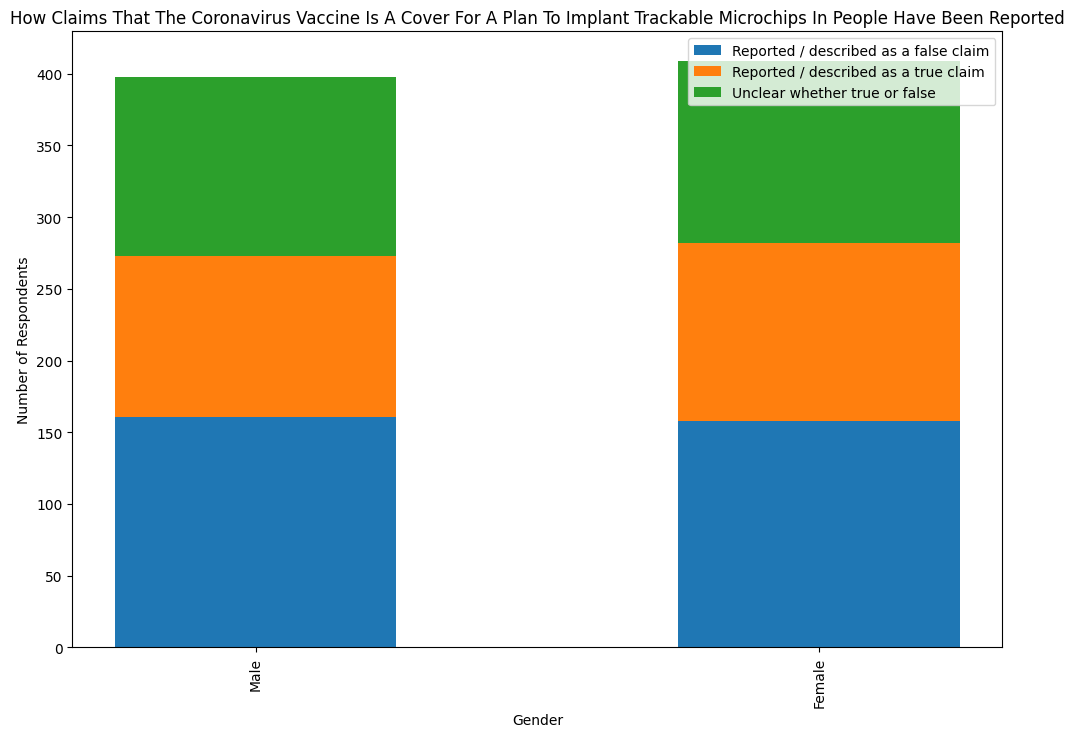

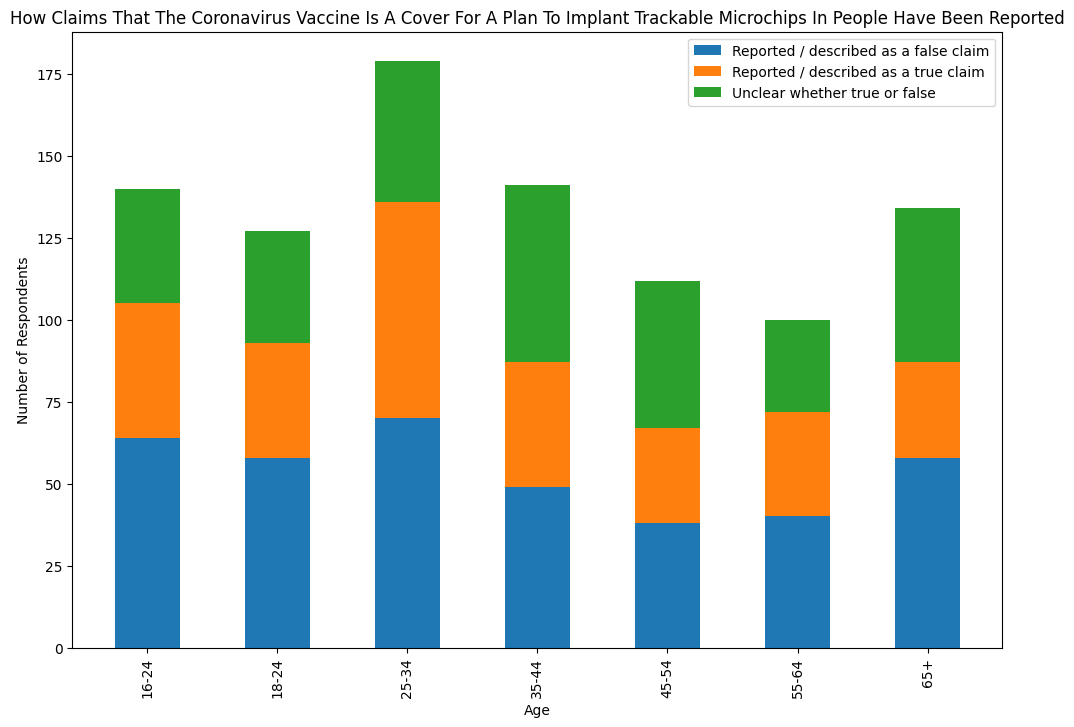

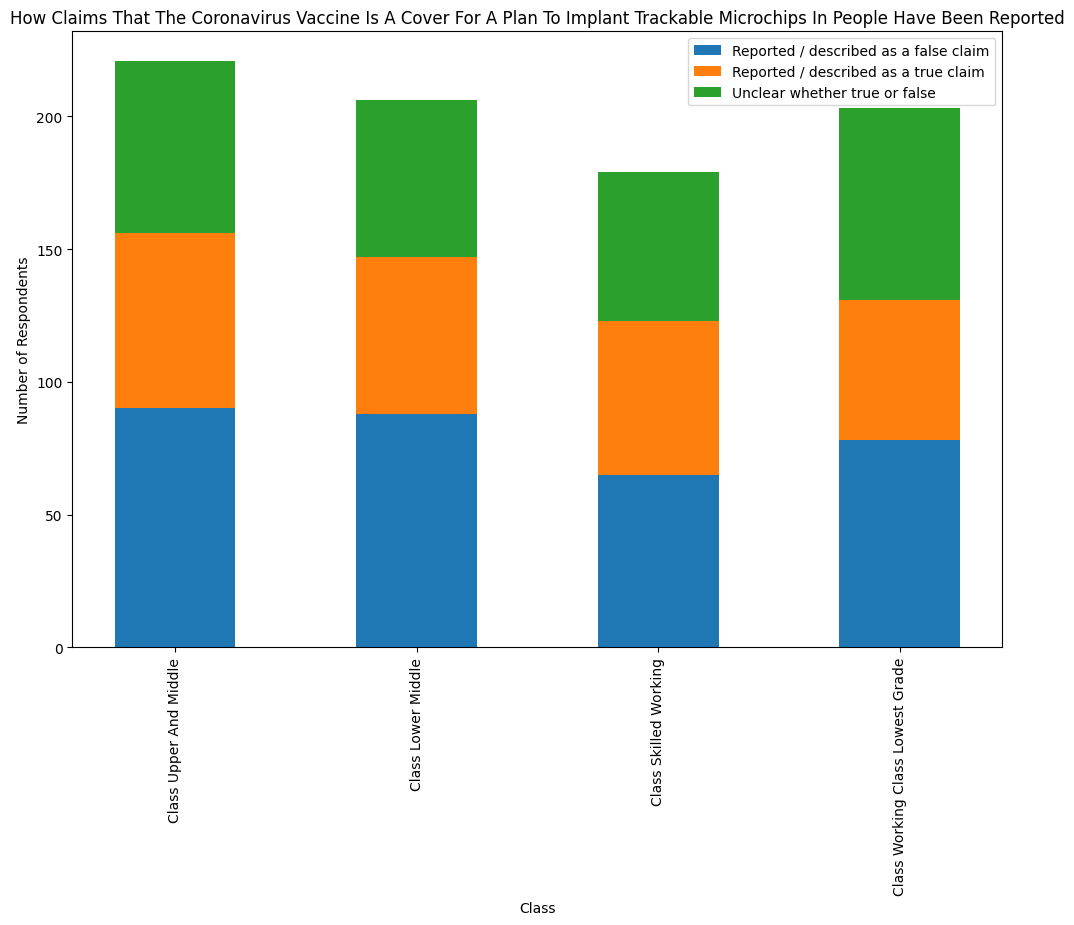

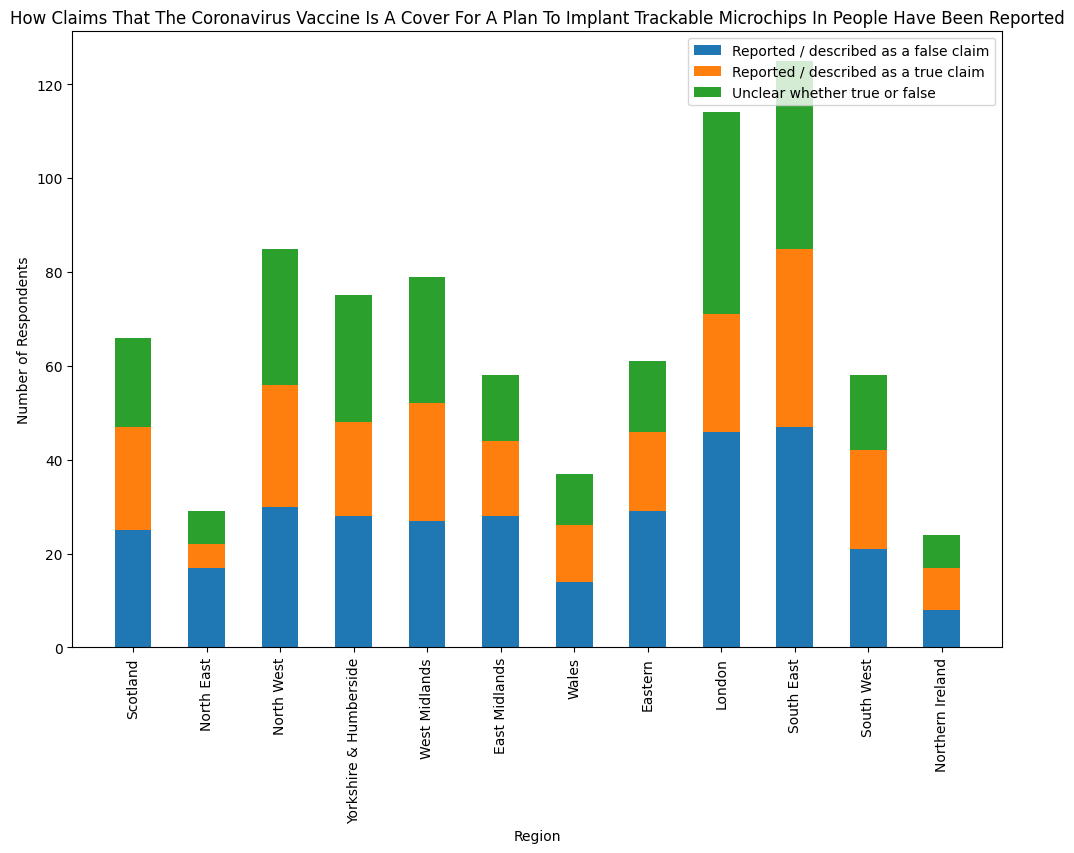

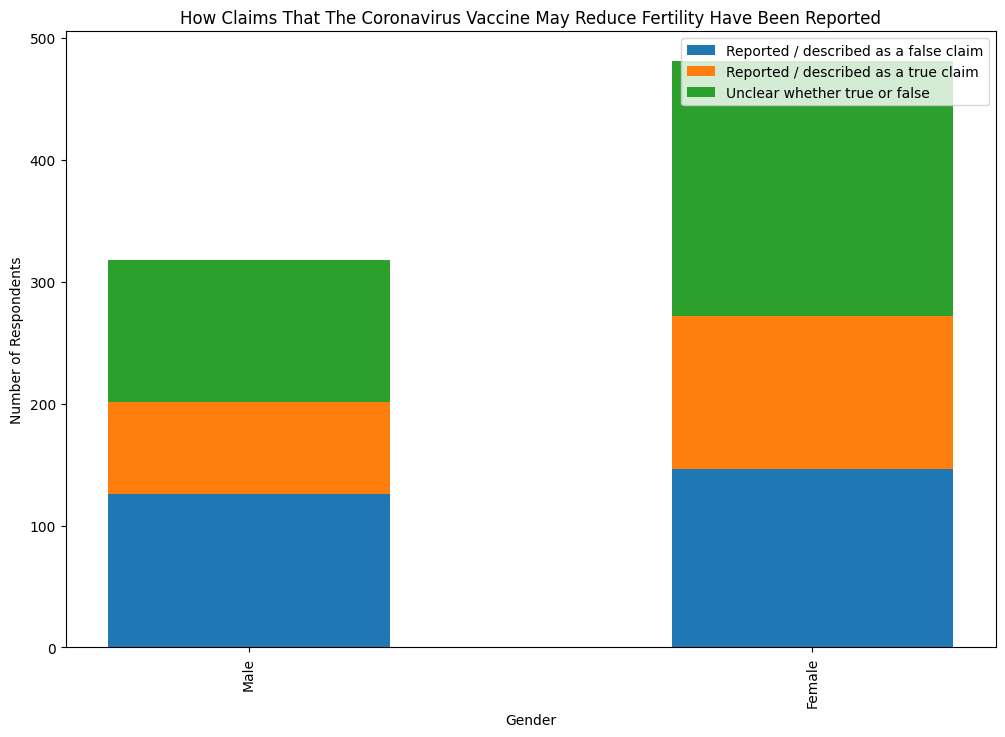

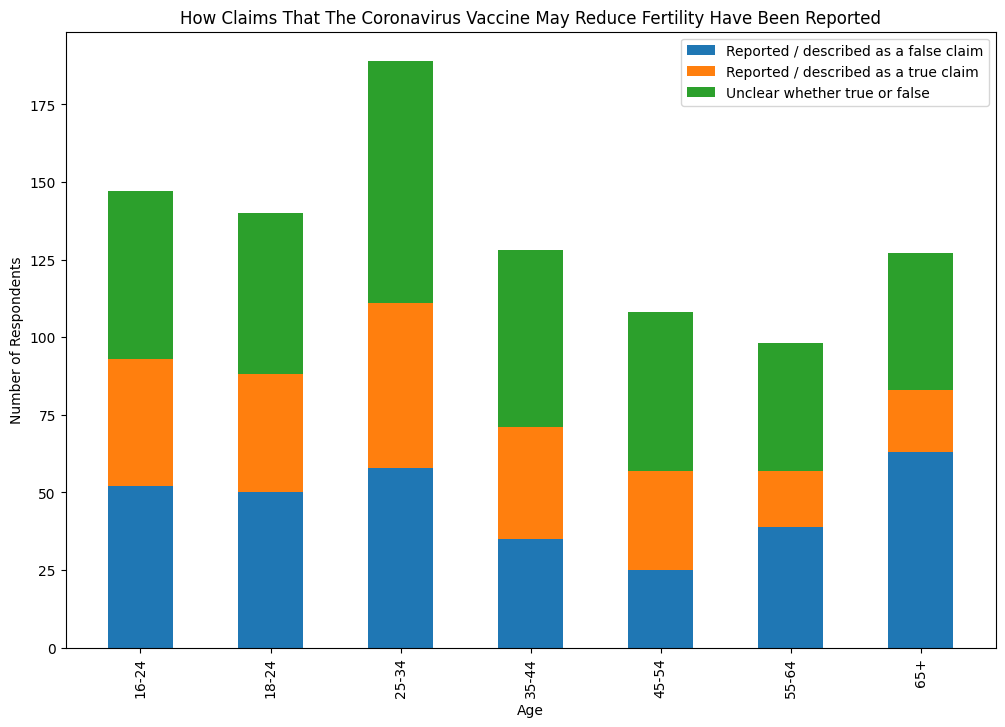

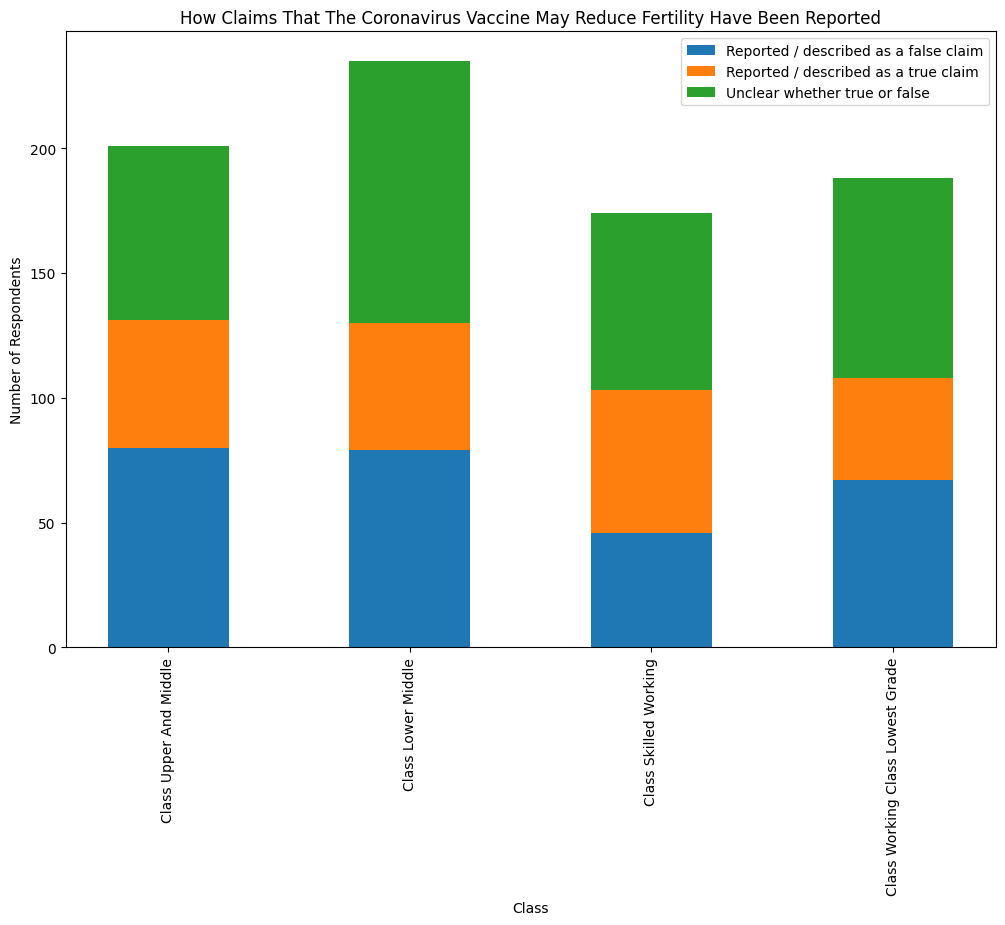

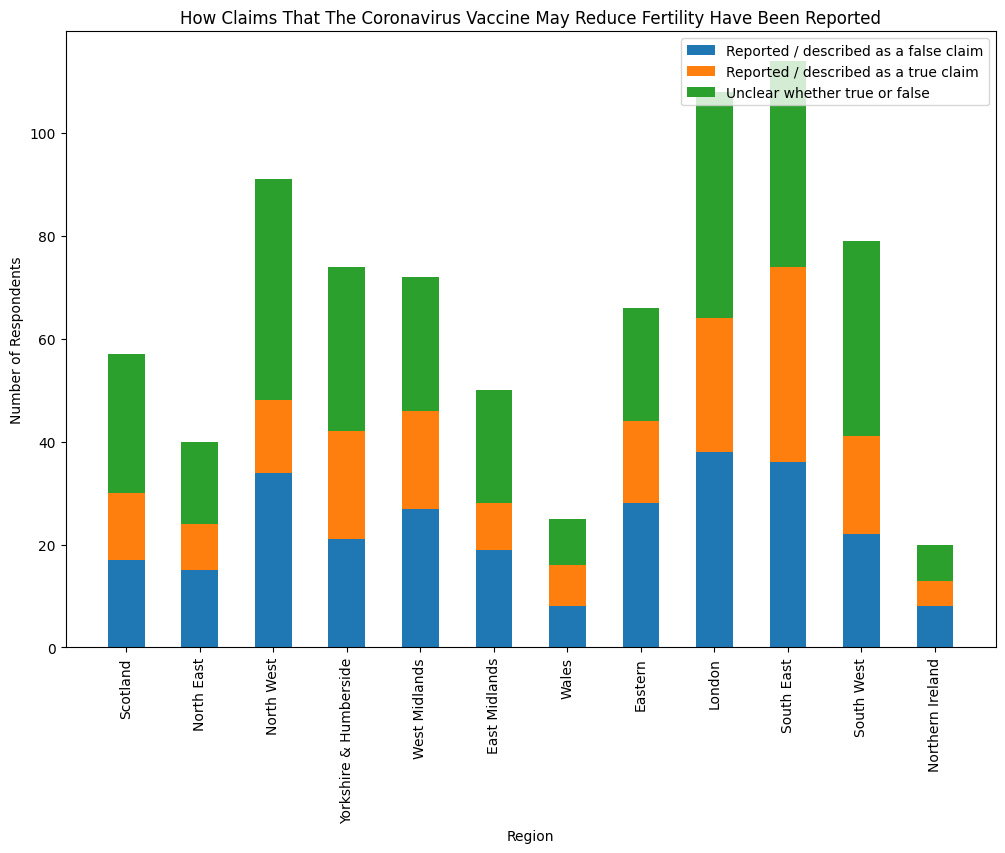

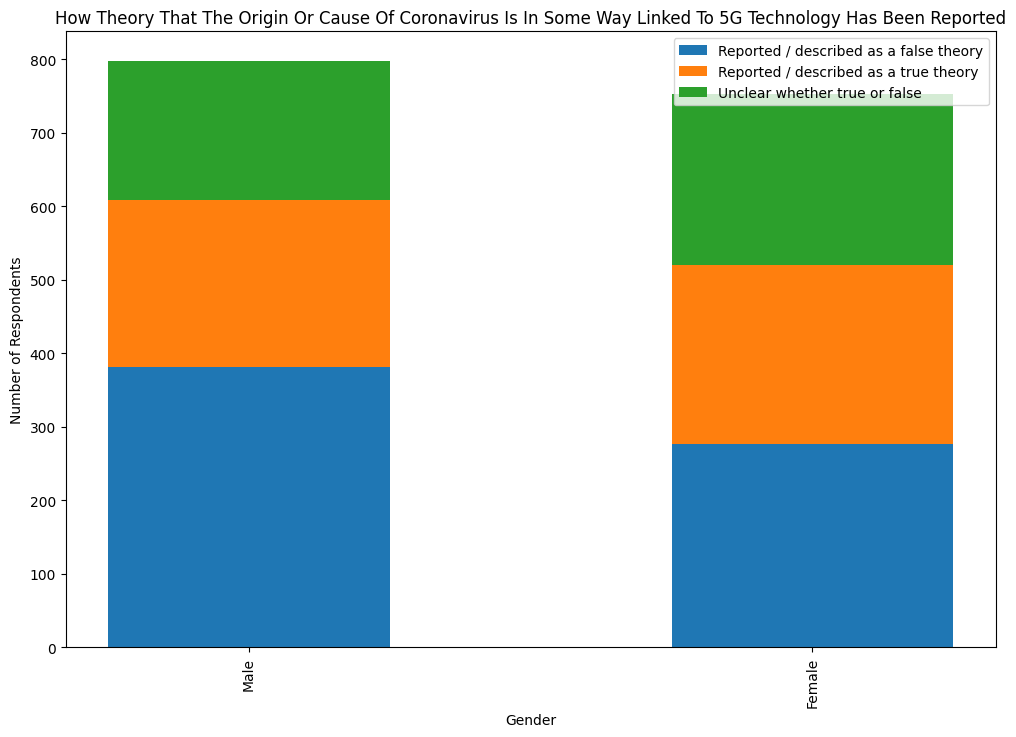

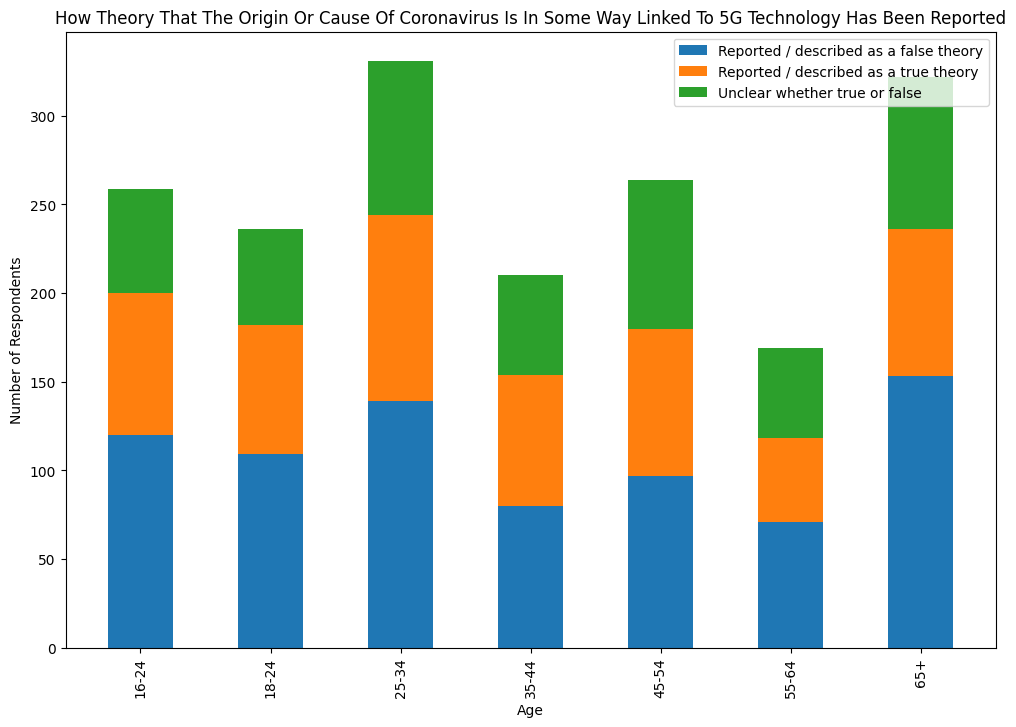

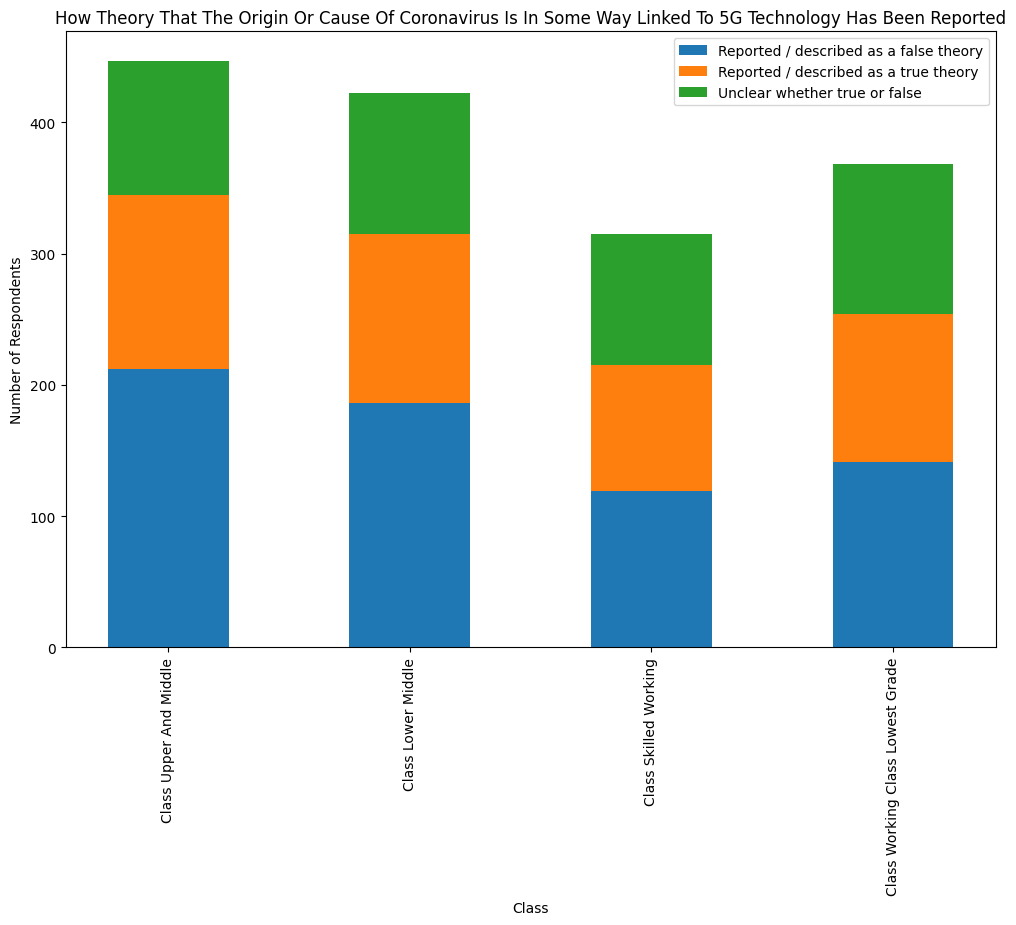

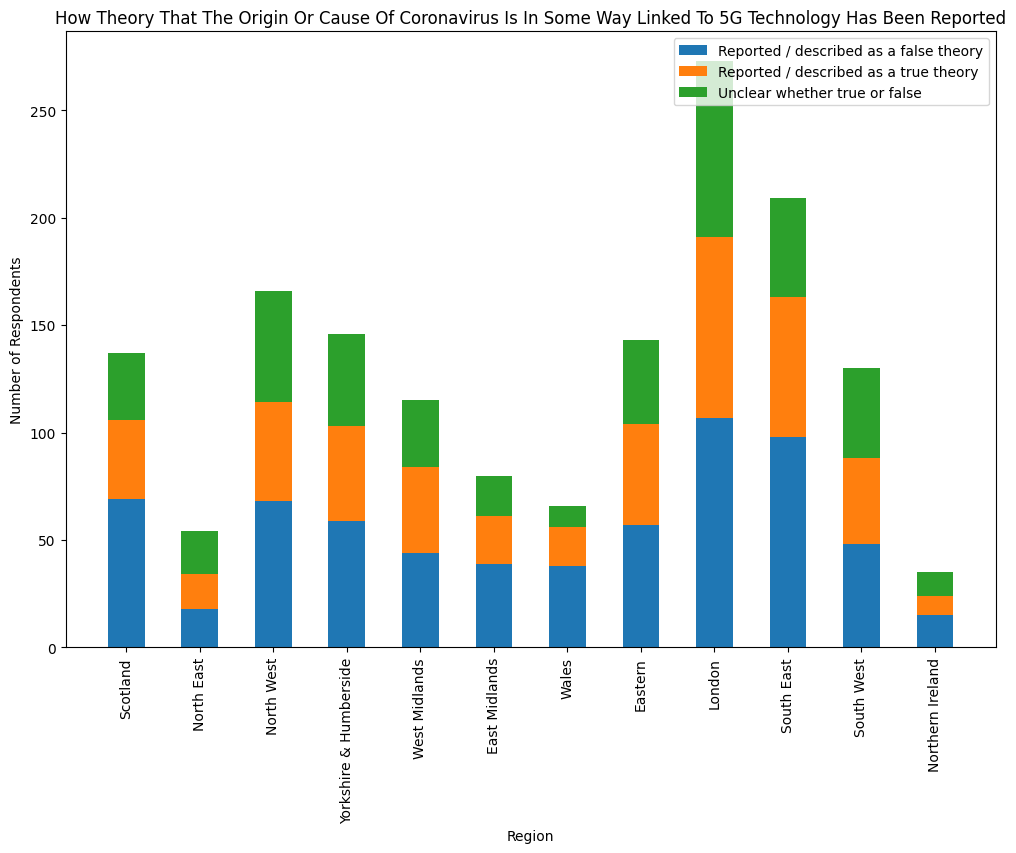

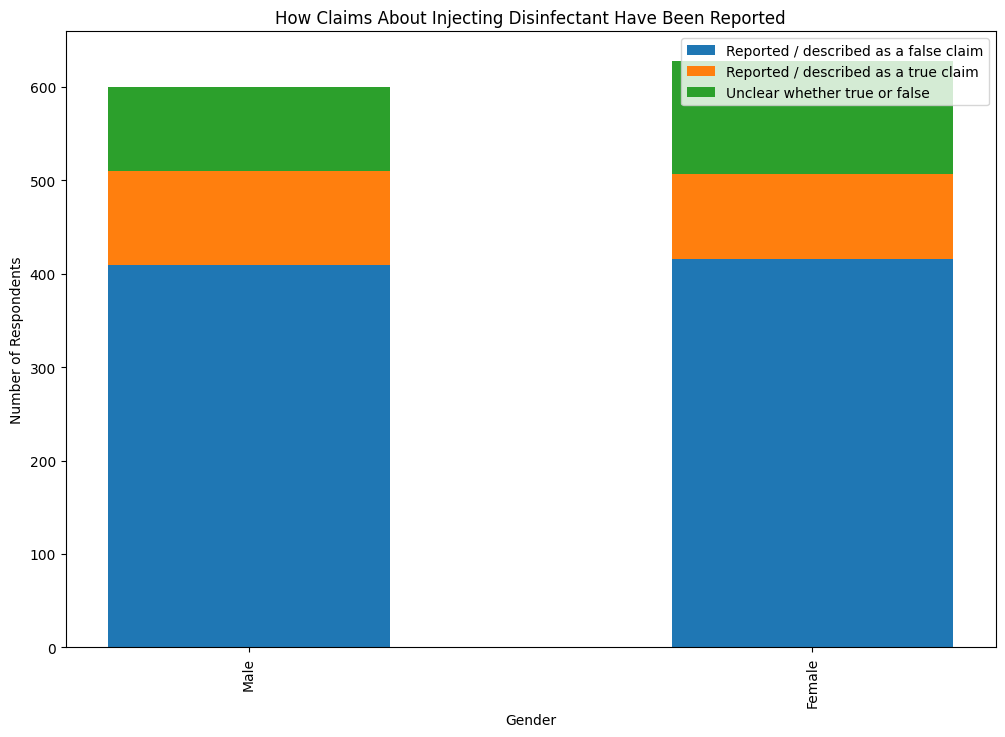

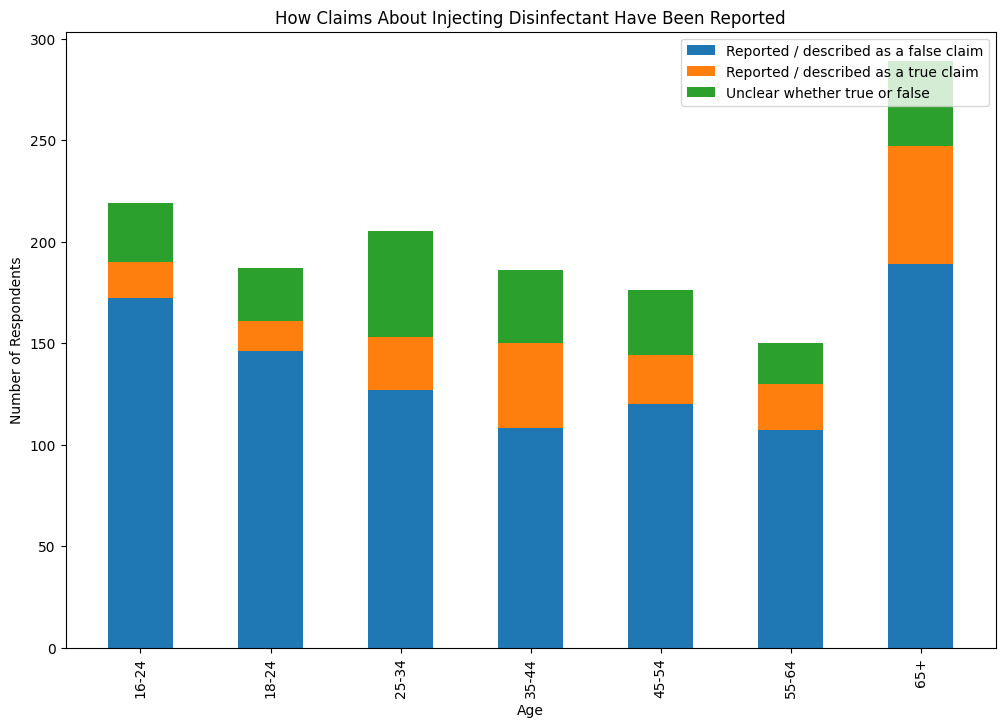

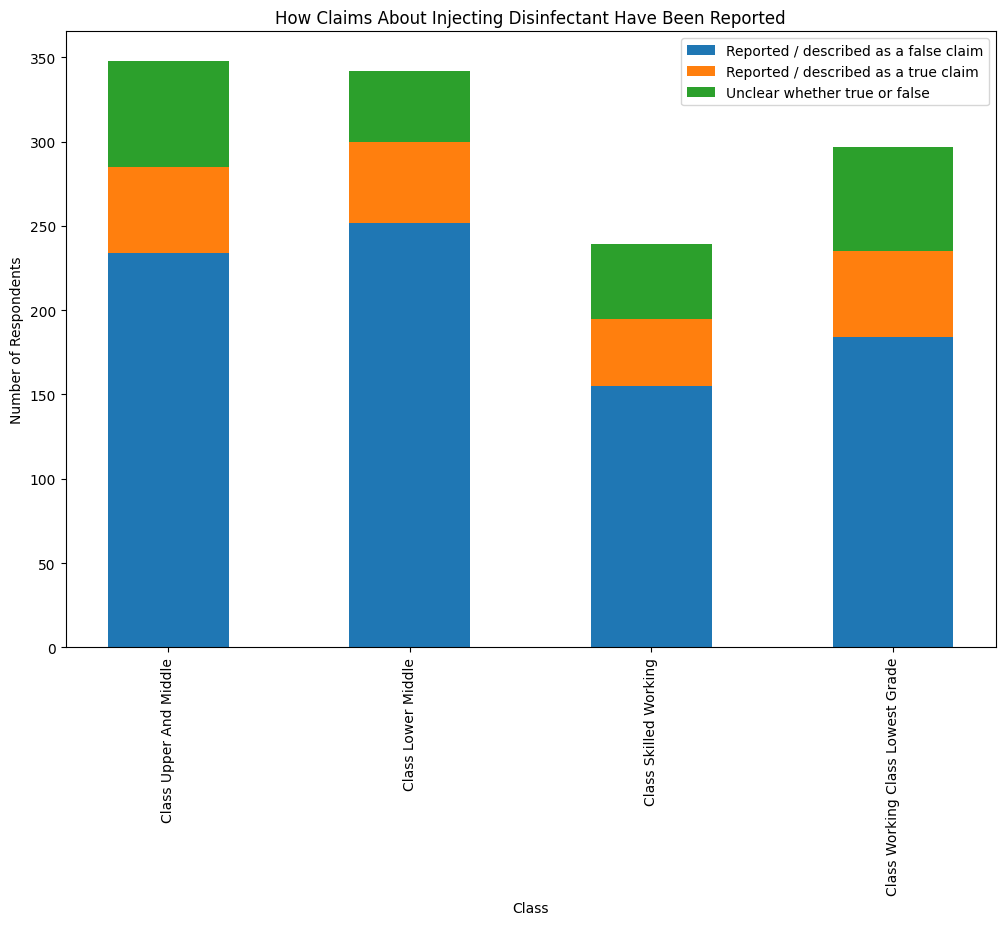

Error when plotting how_claims_about_injecting_disinfectant_have_been_reported region graph


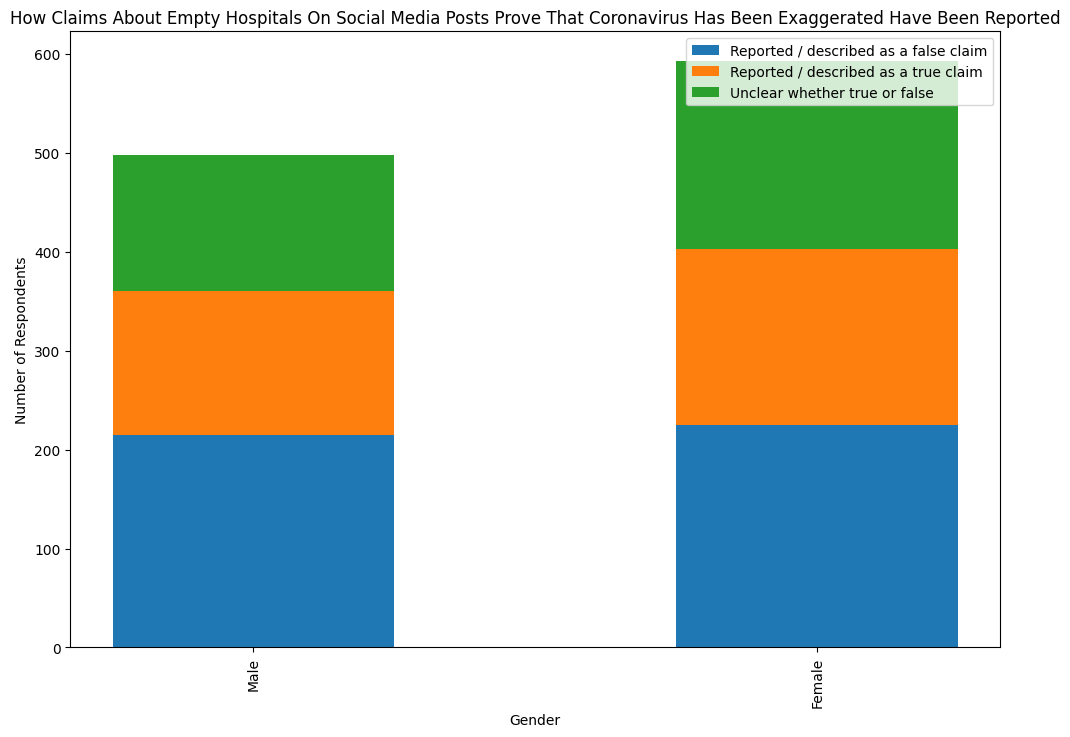

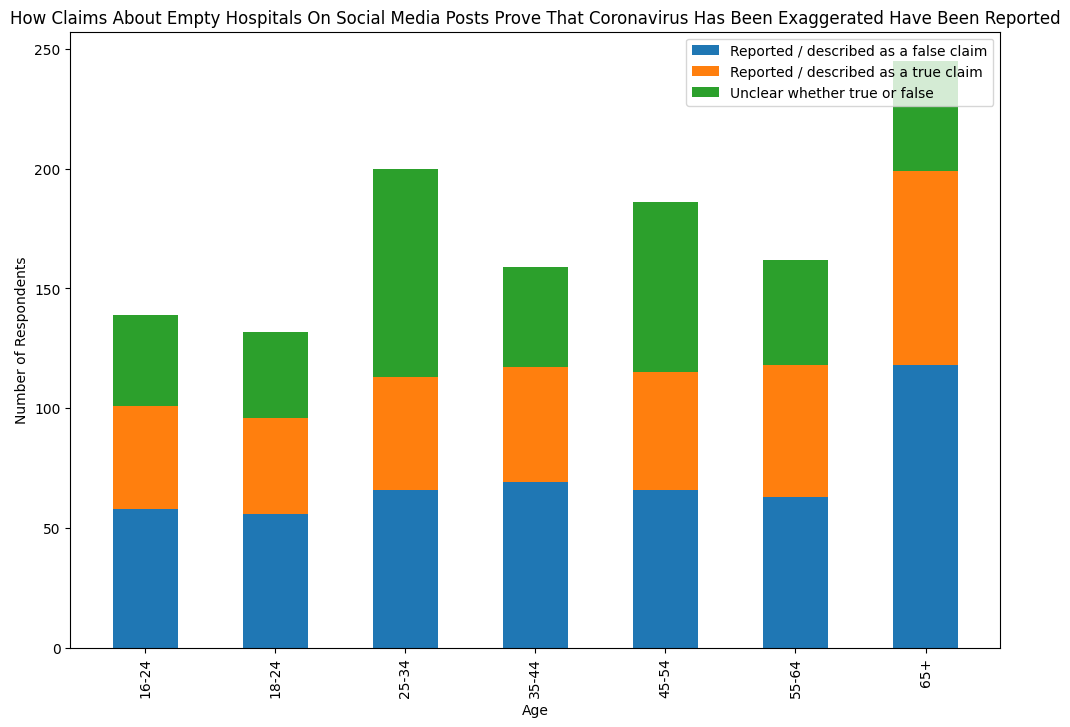

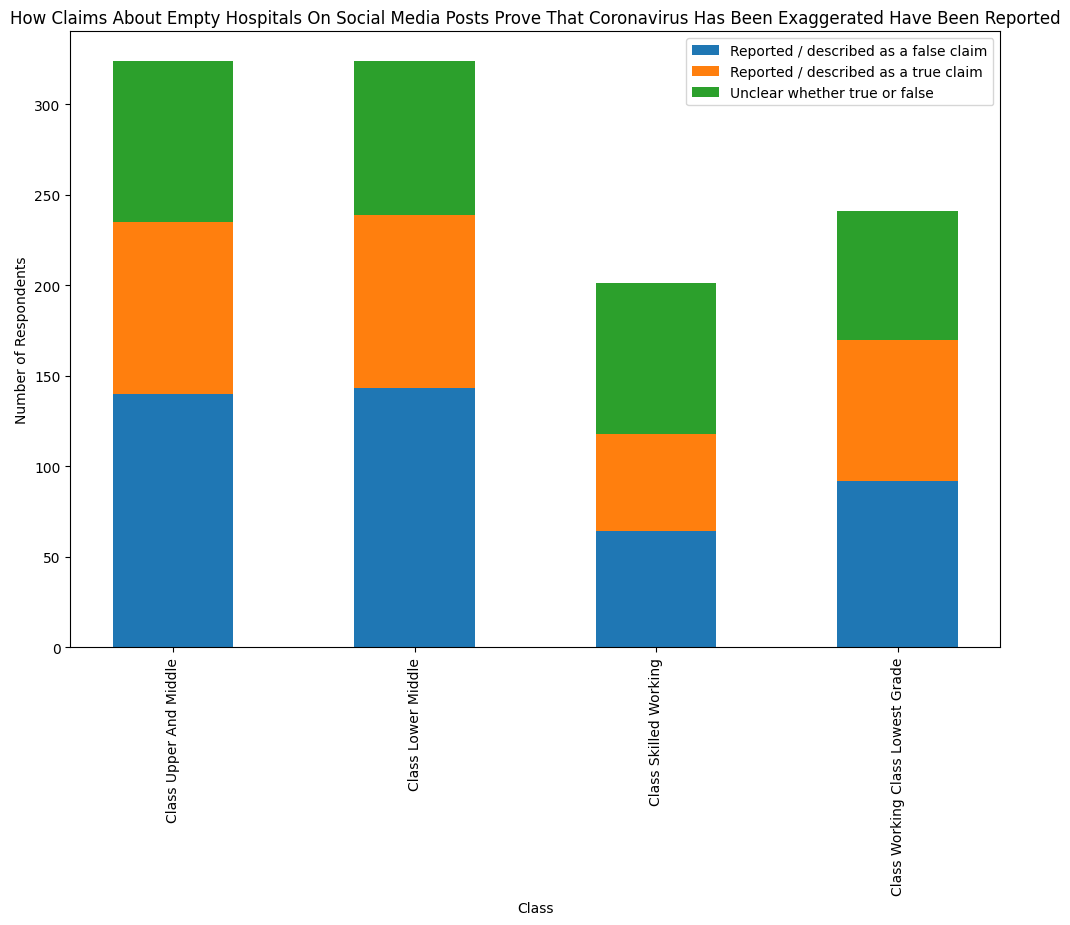

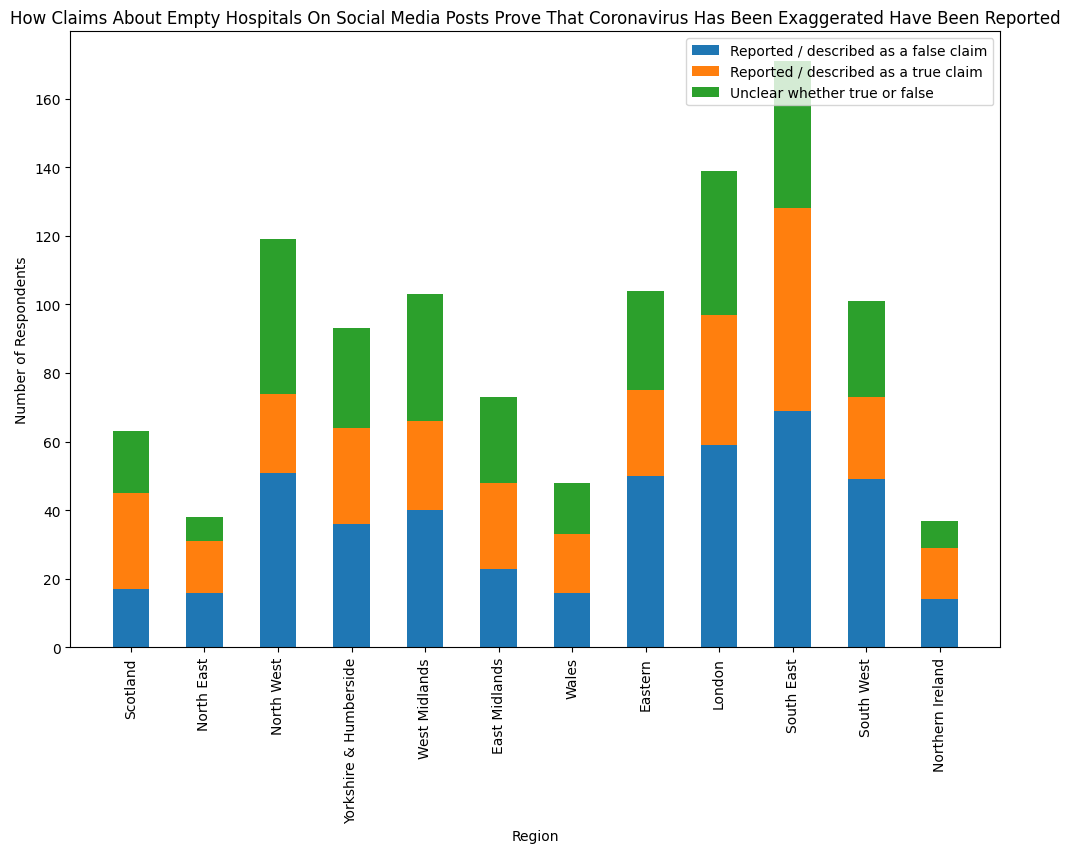

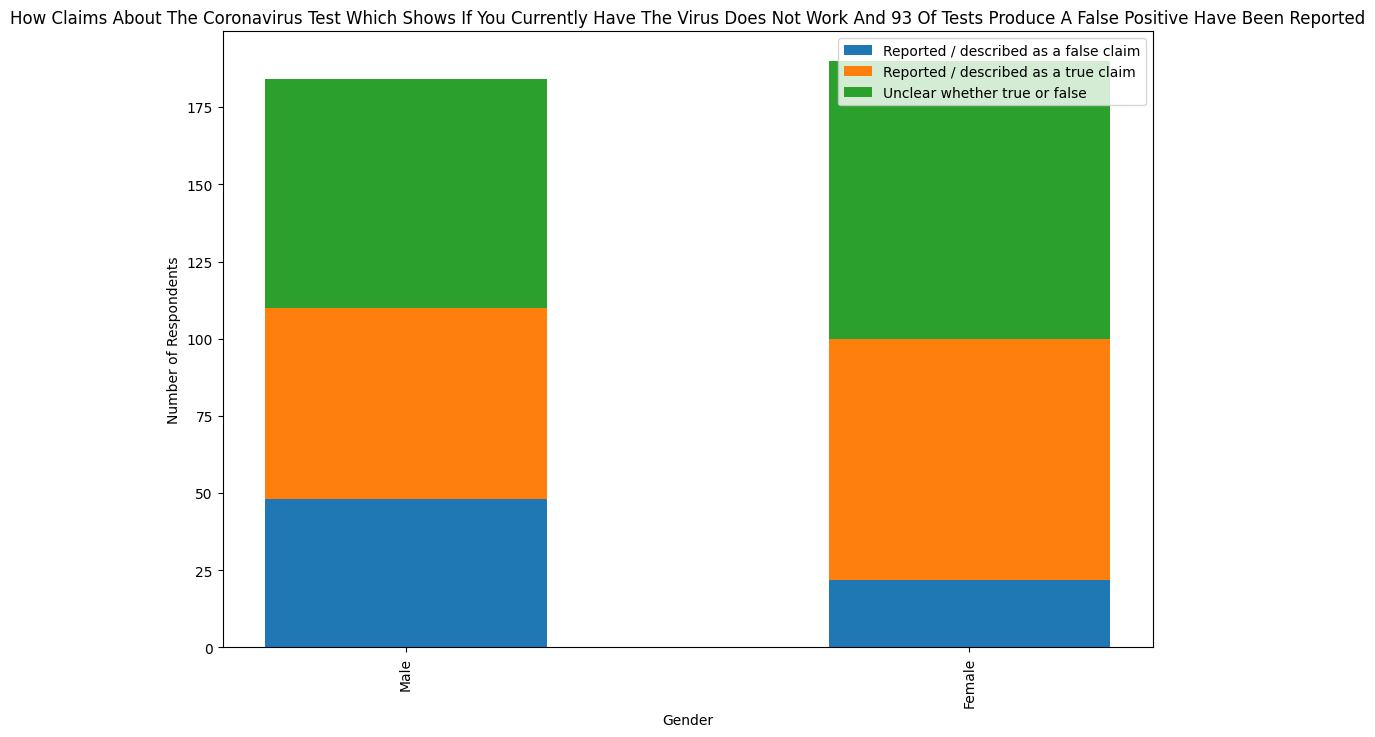

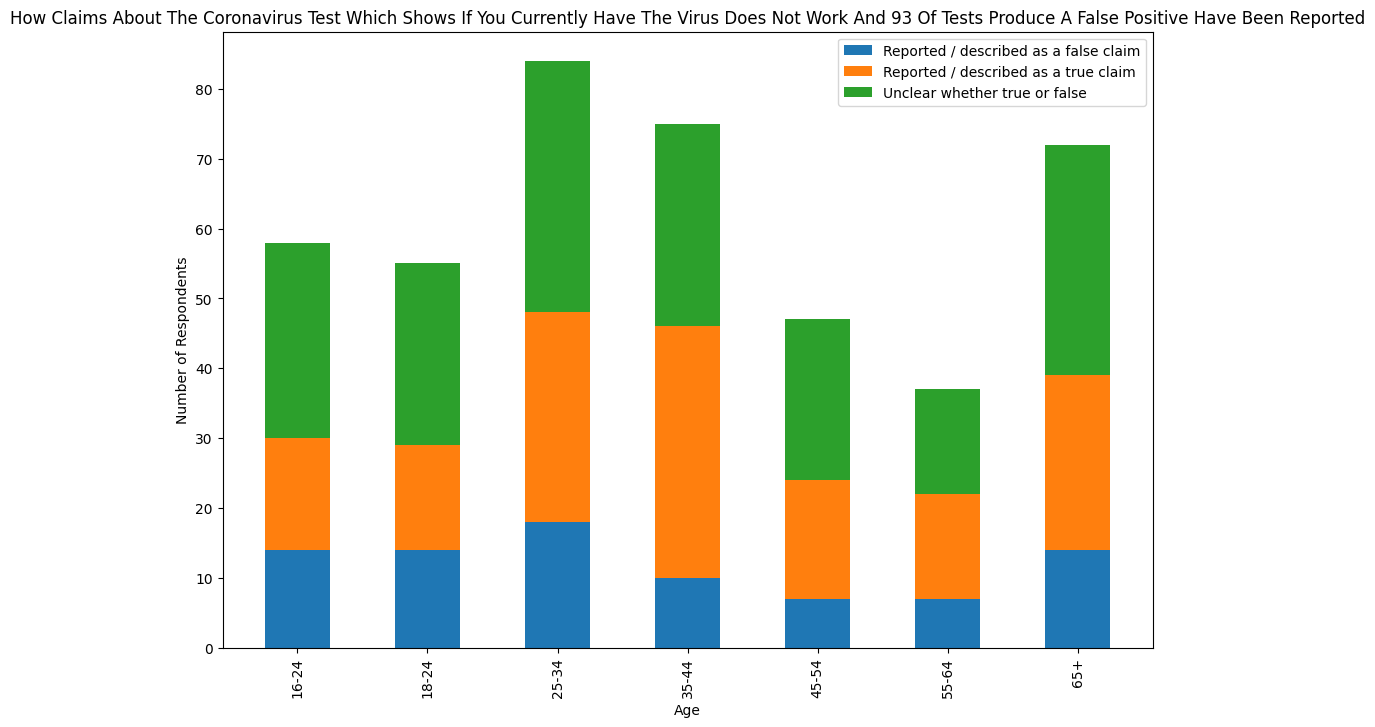

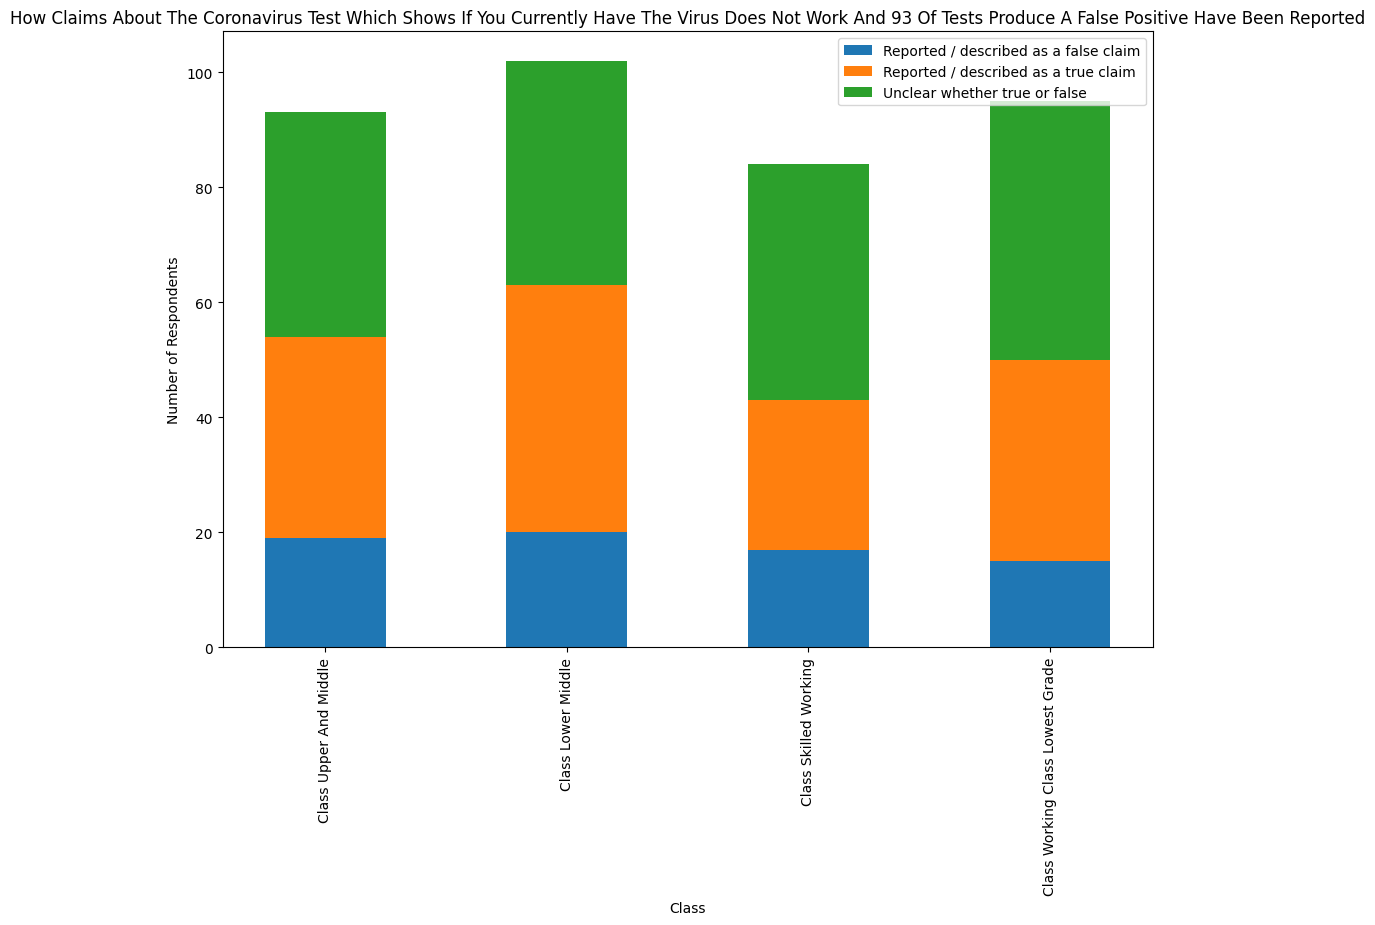

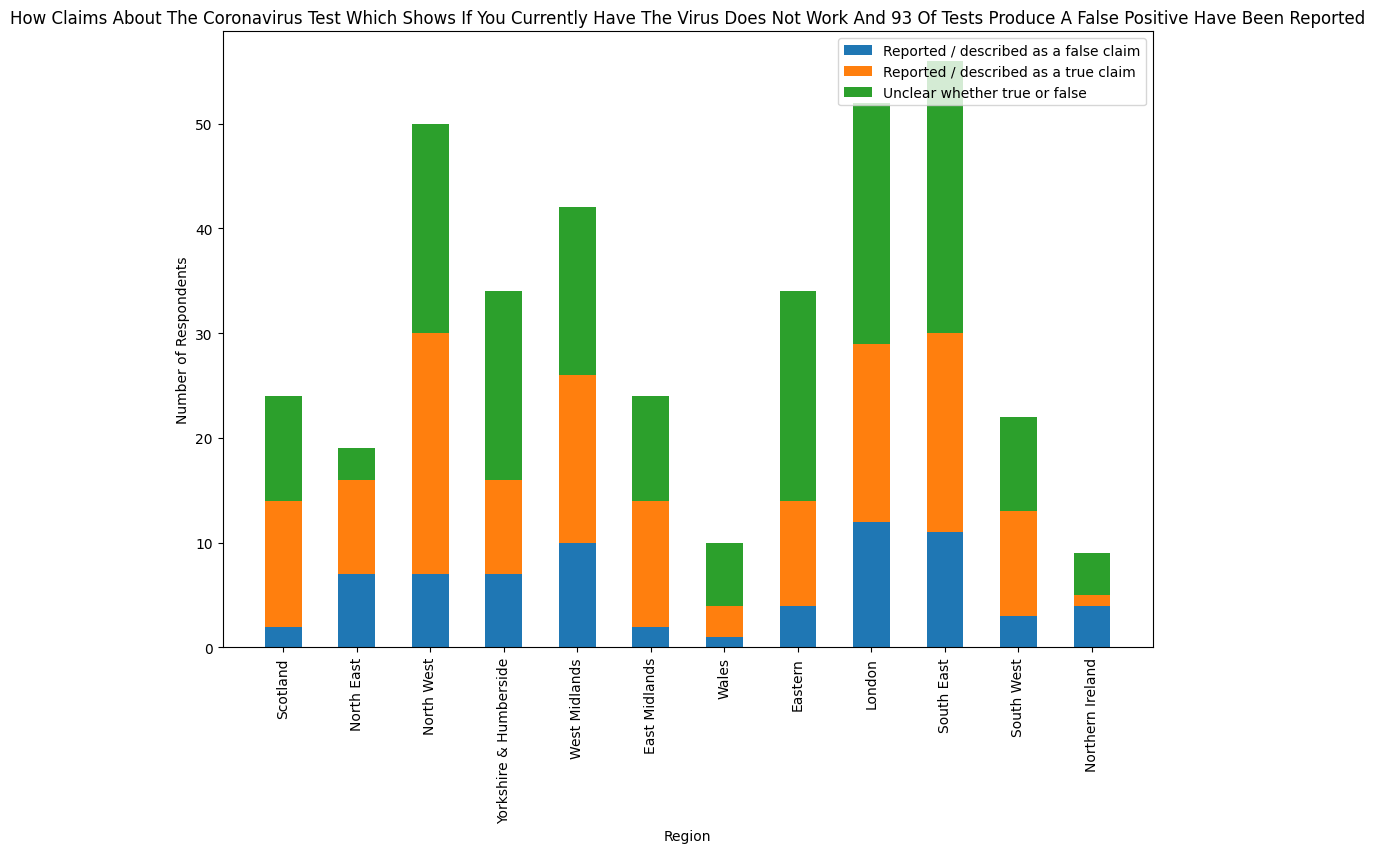

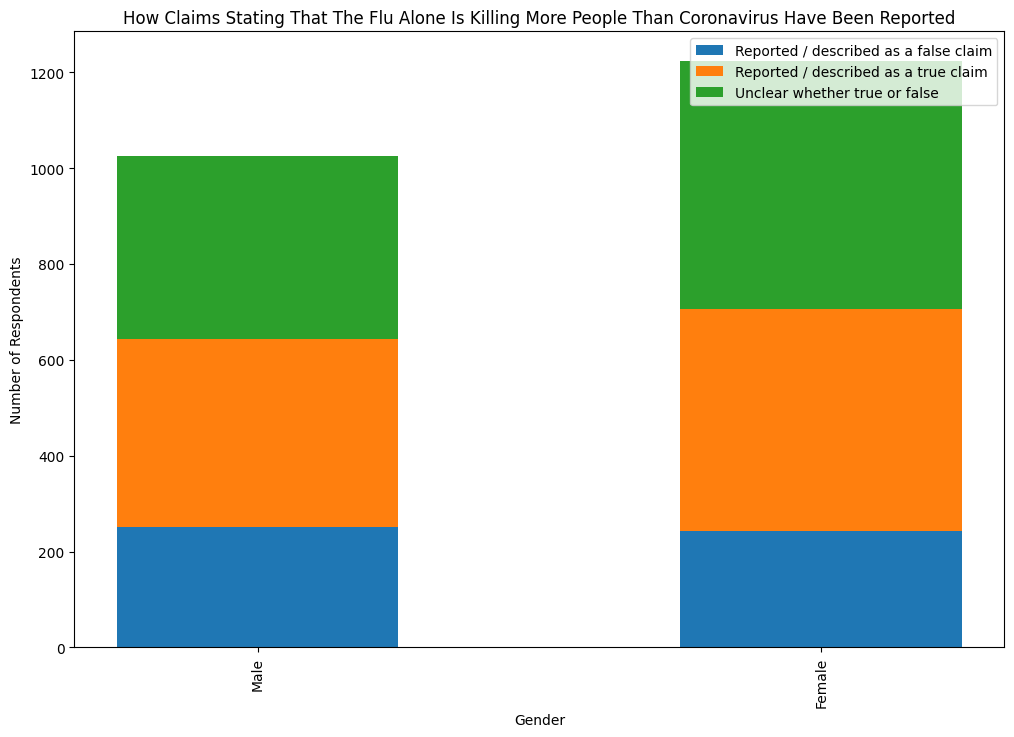

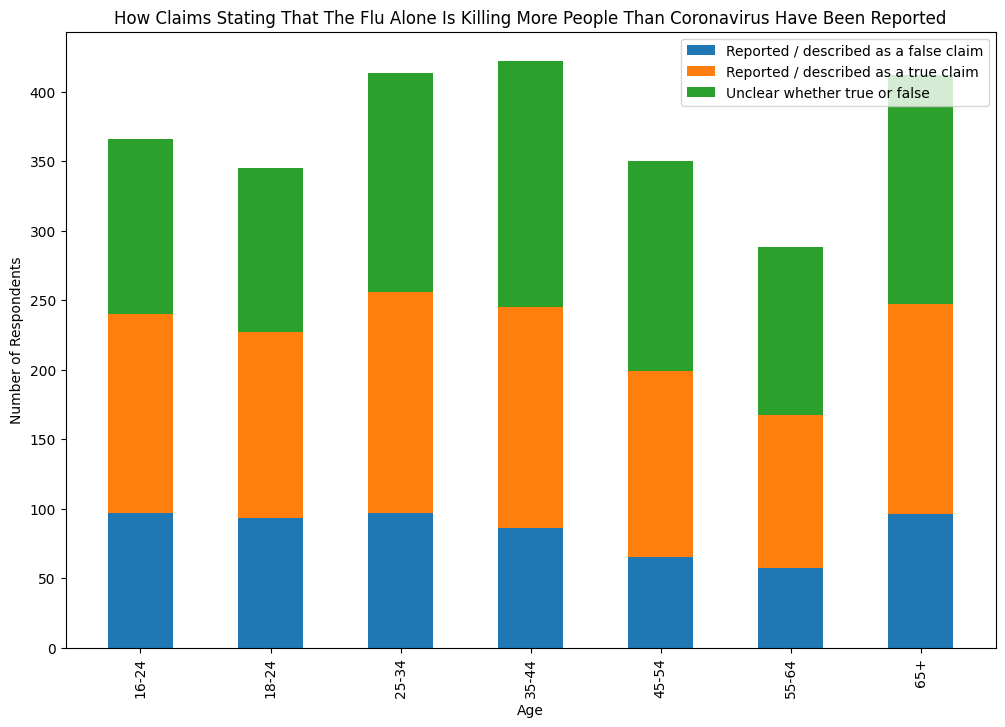

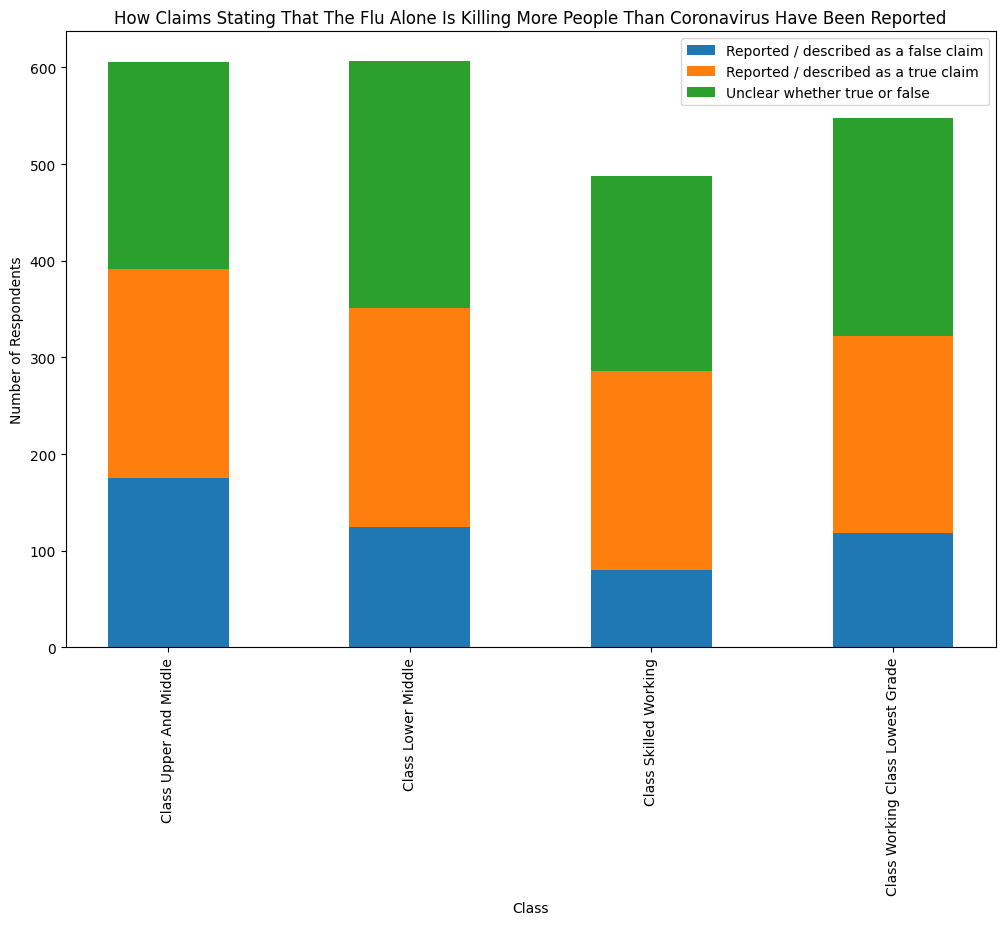

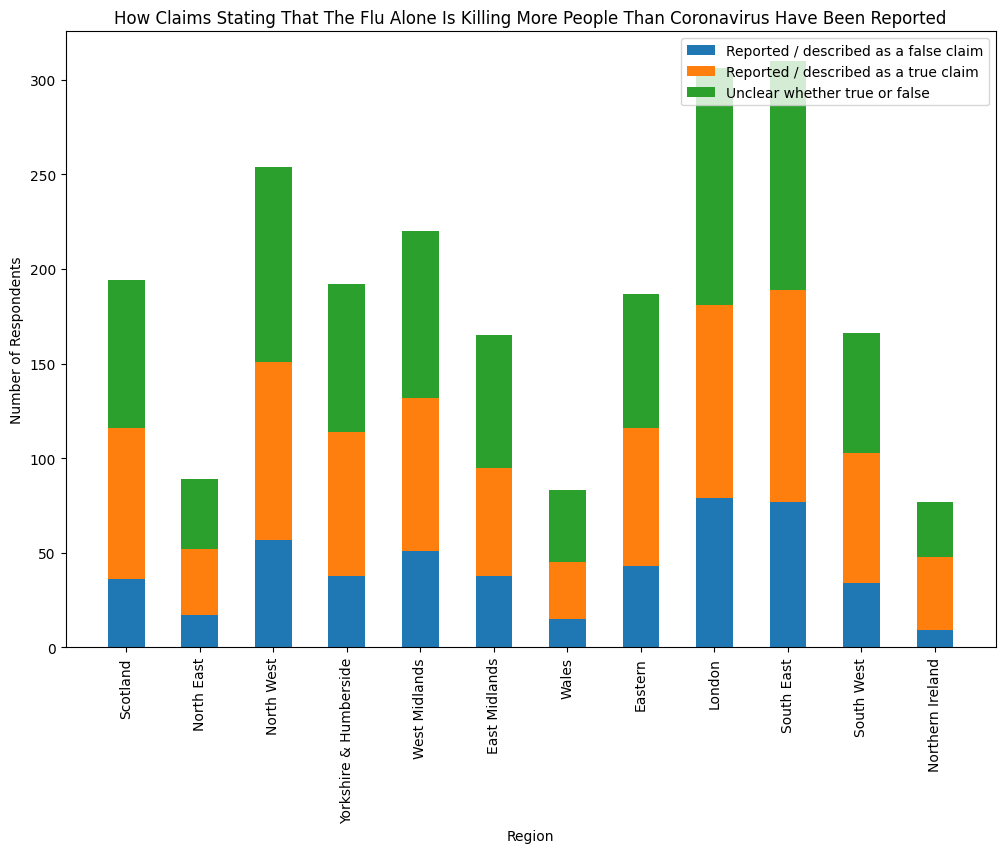

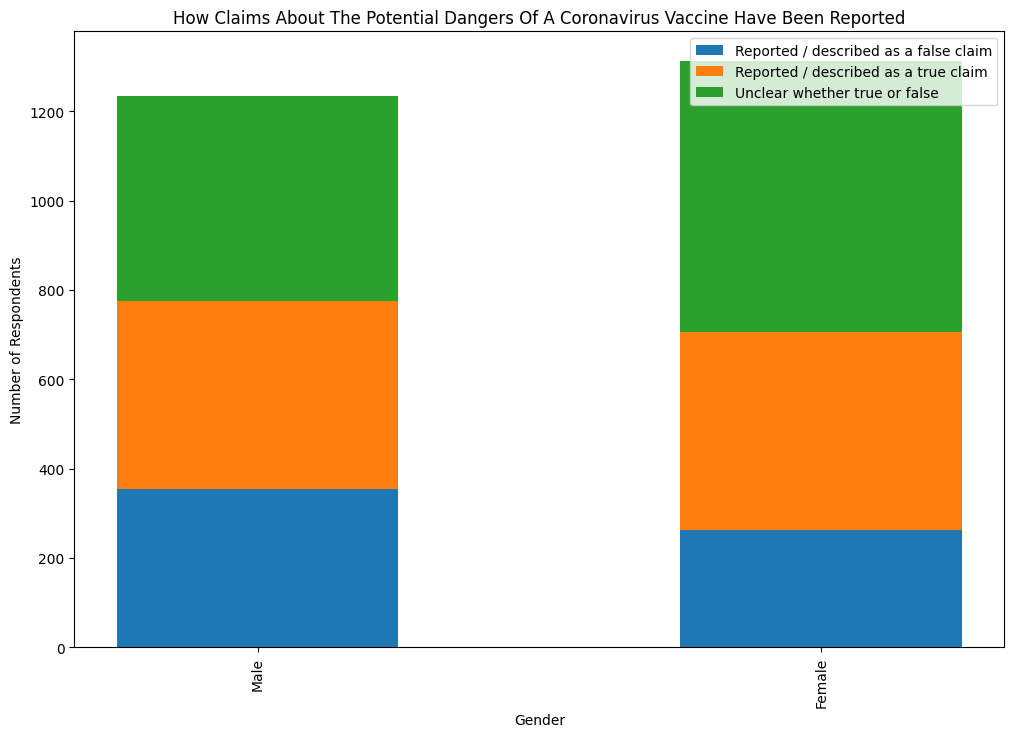

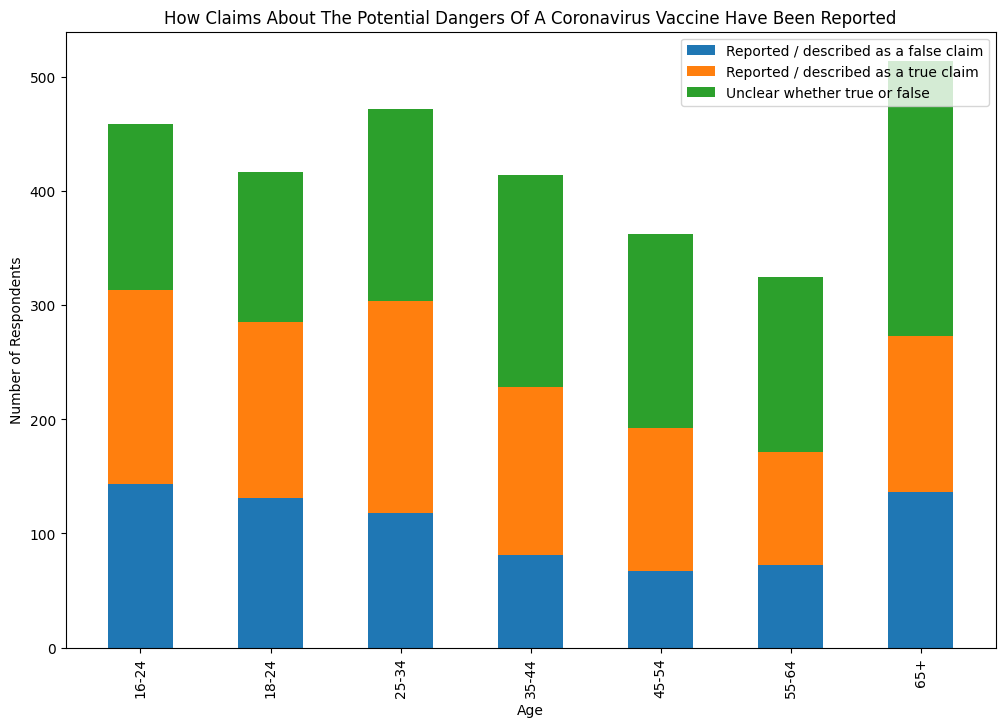

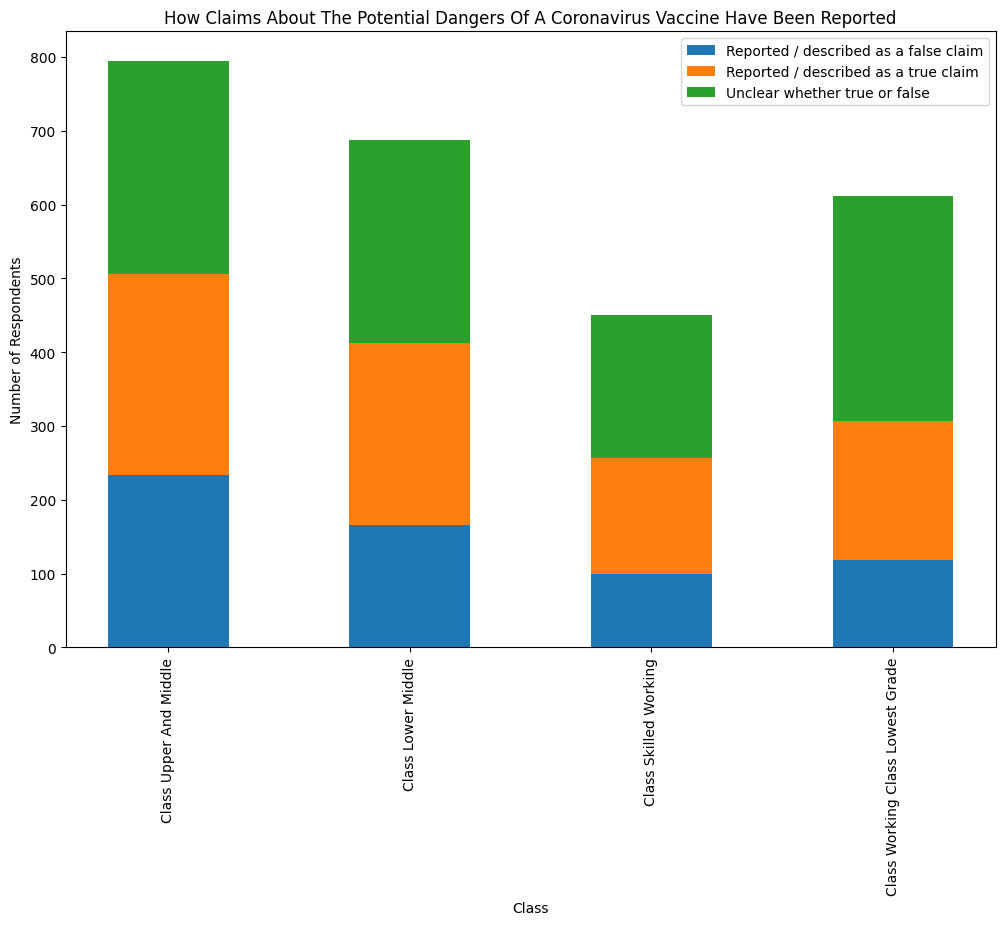

Error when plotting how_claims_about_the_potential_dangers_of_a_coronavirus_vaccine_have_been_reported region graph


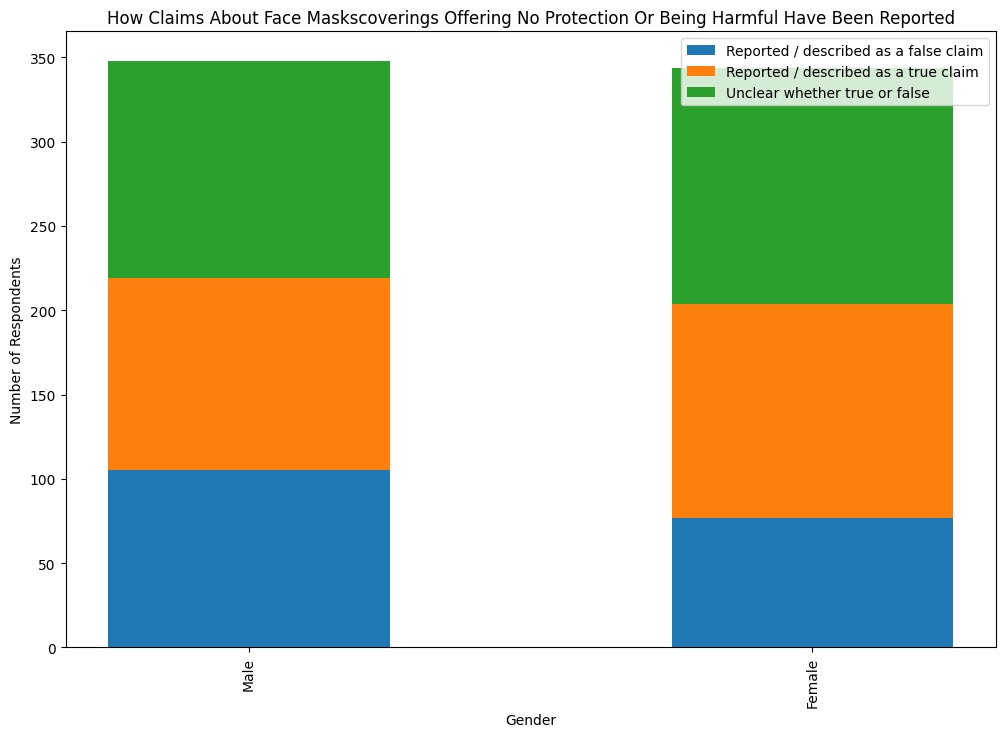

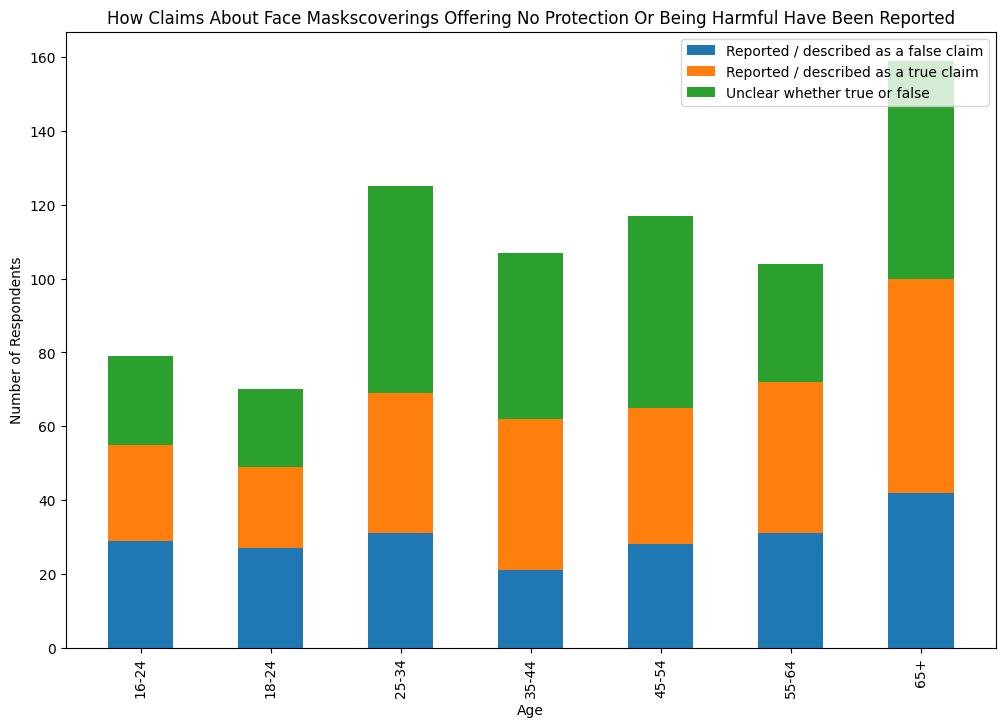

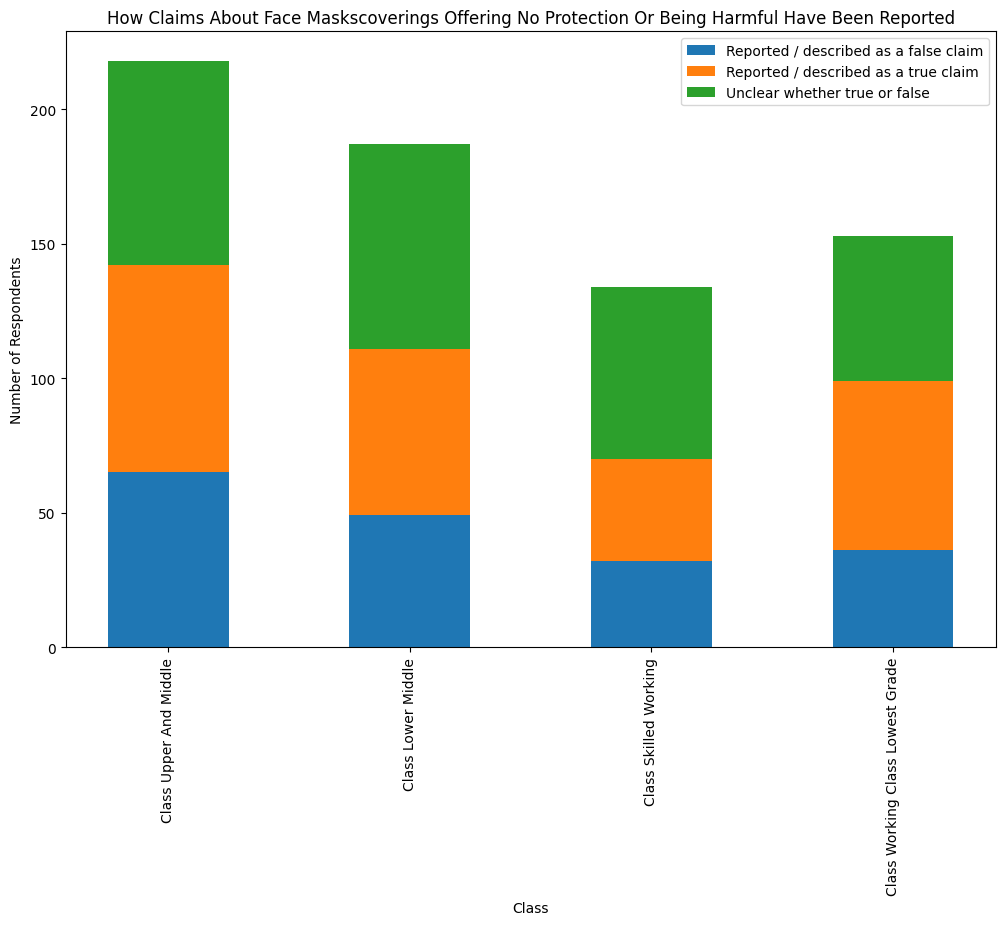

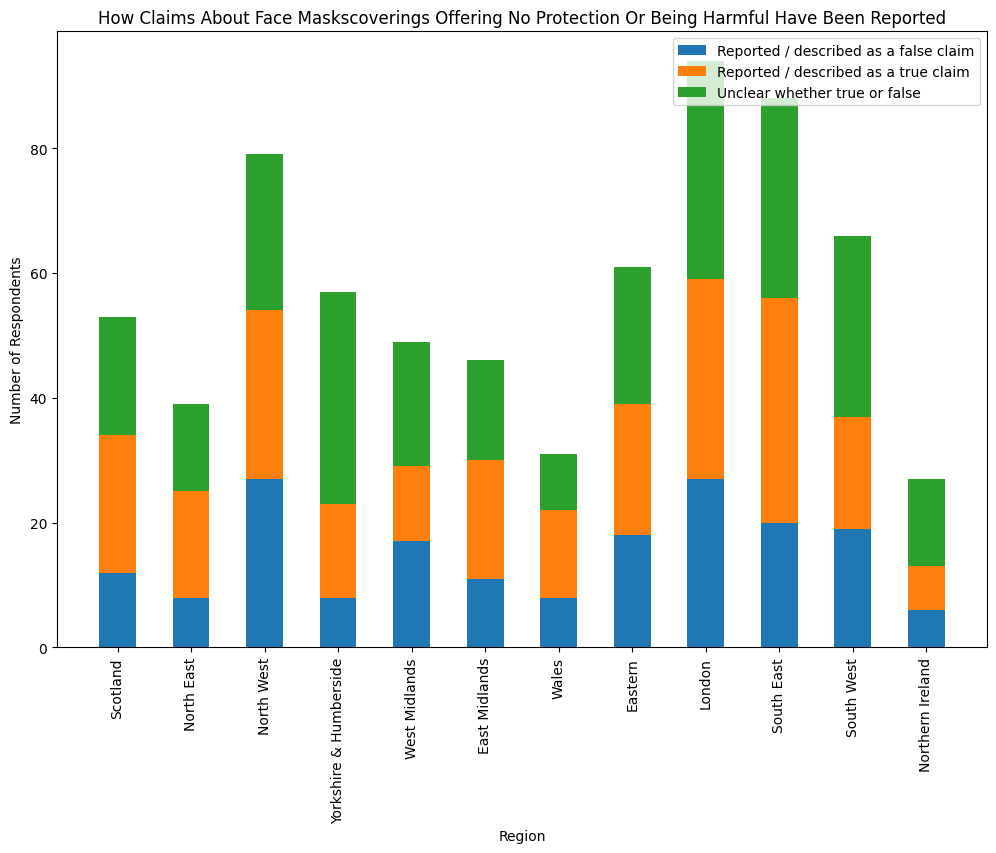

In [106]:
for news in fake_news:
    misinformation_dataframe = ofcom_dataframes[news]
    
    for category, category_list in categories.items():
        
        try:
        
            formatted_labels = [c.title().replace('_', ' ') for c in category_list]
            
            copy_df = misinformation_dataframe.copy()
                    
            columns = category_list + ['response', 'start_date']
            copy_df = copy_df[columns]
    
            aggregated_df = copy_df.groupby(['response'])[category_list].sum().reset_index()
            
            aggregated_df = aggregated_df.loc[~aggregated_df['response'].isin(['Weighted base', 'Unweighted base'])] 
                
            groups = tuple(category_list)
    
            response_dict = {}
            
            response_list = []
            
            response_df = aggregated_df['response']
    
            for response in response_df:
                response_dict[response] = []
                response_list.append(response)
                    
            for i, group in enumerate(groups):
                response_df = aggregated_df['response']
                
                filter_df = aggregated_df[group]
                
                filter_df = filter_df.loc[~aggregated_df['response'].isin(['Weighted base', 'Unweighted base'])]
                
                for i, value in enumerate(filter_df):
                    response_dict[response_list[i]].append(value)
            
            for key, value in response_dict.items():
                response_dict[key] = np.array(value)
            
            width = 0.5
    
            fig, ax = plt.subplots(figsize=(12, 8))
            bottom = np.zeros(len(category_list))
            
            for group, response_count in response_dict.items():
                p = ax.bar(groups, response_count, width, label=group, bottom=bottom)
                bottom += response_count
    
            ax.set_title(f"{news.replace('_', ' ').title()}")
            
            ax.legend(loc="upper right")
                    
            plt.xticks(ticks=range(len(groups)), labels=formatted_labels, rotation=90)
            
            plt.ylabel("Number of Respondents")
            
            plt.xlabel(category.title())


            plt.savefig(f'3_final_figures/misinformation_ofcom/how_false_news_has_been_reported/{news}_{category}.png', dpi=300)
            
            plt.show()
            
        except KeyError:
            print(f"Error when plotting {news} {category} graph")
        

In [107]:
ofcom_dataframes['whether_came_across_any_of_these_false_or_misleading_recommendations_about_avoiding_the_coronavirus_in_the_last_week']

start_date    end_date                                           question  \
0   2020-03-27  2020-03-29  whether_came_across_any_of_these_false_or_misl...   
1   2020-03-27  2020-03-29  whether_came_across_any_of_these_false_or_misl...   
2   2020-03-27  2020-03-29  whether_came_across_any_of_these_false_or_misl...   
3   2020-03-27  2020-03-29  whether_came_across_any_of_these_false_or_misl...   
4   2020-03-27  2020-03-29  whether_came_across_any_of_these_false_or_misl...   
..         ...         ...                                                ...   
57  2020-04-24  2020-04-26  whether_came_across_any_of_these_false_or_misl...   
58  2020-04-24  2020-04-26  whether_came_across_any_of_these_false_or_misl...   
59  2020-04-24  2020-04-26  whether_came_across_any_of_these_false_or_misl...   
60  2020-04-24  2020-04-26  whether_came_across_any_of_these_false_or_misl...   
61  2020-04-24  2020-04-26  whether_came_across_any_of_these_false_or_misl...   

                                             response  total  male  female  \
0                                       None of these   1000   522     478   
1   Putting clothes in the sun or another warm pla...    239   107     132   
2   Increasing use of natural remedies such as col...    488   204     284   
3   Eating warm food/ drink and avoiding cold food...    528   228     300   
4                            Gargling with salt water    538   224     314   
..                                                ...    ...   ...     ...   
57                                           NET: Any   1307   659     648   
58                                      Weighted base   2077  1018    1059   
59                                    Unweighted base   2077  1029    1048   
60                       Exposure to UV/ strong light     23    12      11   
61                     Drinking water more frequently    347   150     197   

    16-24  class_upper_and_middle  class_lower_middle  class_skilled_working  \
0     0.0                     257                 281                    197   
1     0.0                      68                  65                     53   
2     0.0                     150                 137                     94   
3     0.0                     153                 155                    102   
4     0.0                     155                 153                    115   
..    ...                     ...                 ...                    ...   
57  198.0                     399                 363                    266   
58  286.0                     571                 587                    420   
59  263.0                     542                 614                    387   
60    4.0                       7                  10                      4   
61   56.0                     108                  94                     72   

    class_working_class_lowest_grade  
0                                264  
1                                 52  
2                                107  
3                                118  
4                                116  
..                               ...  
57                               279  
58                               499  
59                               534  
60                                 1  
61                                73  

[62 rows x 12 columns]